In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy
import string
import warnings
import pickle
import os

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network

In [11]:
from ana_functions.train_DBN import train_DBN

### function - train the dynamic bayesian network - Alec's methods

In [12]:
from ana_functions.train_DBN_alec import train_DBN_alec

### methods used by Alec - separate into different "trials"

In [13]:
from ana_functions.train_DBN_alec import train_DBN_alec_eachtrial

## Analyze each session

analyze all dates
analyze social gaze with camera-2 only of 20220909
analyze social gaze with camera-2 only of 20220912
analyze social gaze with camera-2 only of 20220915
analyze social gaze with camera-2 only of 20220920
analyze social gaze with camera-2 only of 20220922
analyze social gaze with camera-2 only of 20220923
analyze social gaze with camera-2 only of 20221010
analyze social gaze with camera-2 only of 20221011
analyze social gaze with camera-2 only of 20221013
analyze social gaze with camera-2 only of 20221014
analyze social gaze with camera-2 only of 20221015
analyze social gaze with camera-2 only of 20221017
analyze social gaze with camera-2 only of 20221018
analyze social gaze with camera-2 only of 20221019
analyze social gaze with camera-2 only of 20221020
analyze social gaze with camera-2 only of 20221021
analyze social gaze with camera-2 only of 20221022
analyze social gaze with camera-2 only of 20221026
analyze social gaze with camera-2 only of 20221028
analyze socia

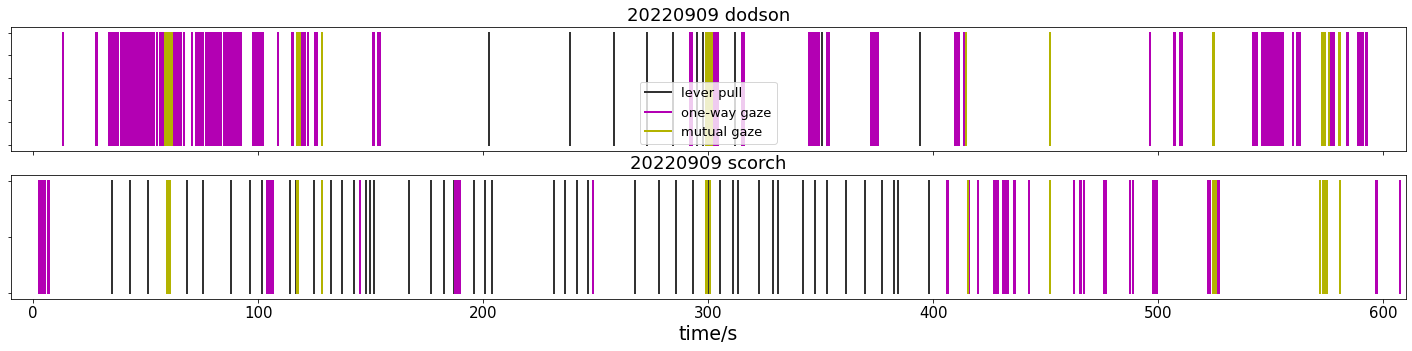

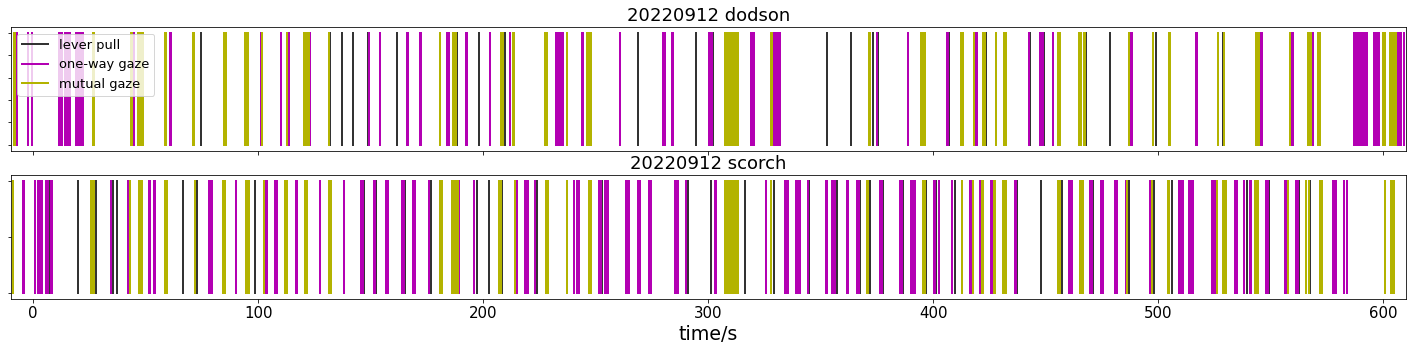

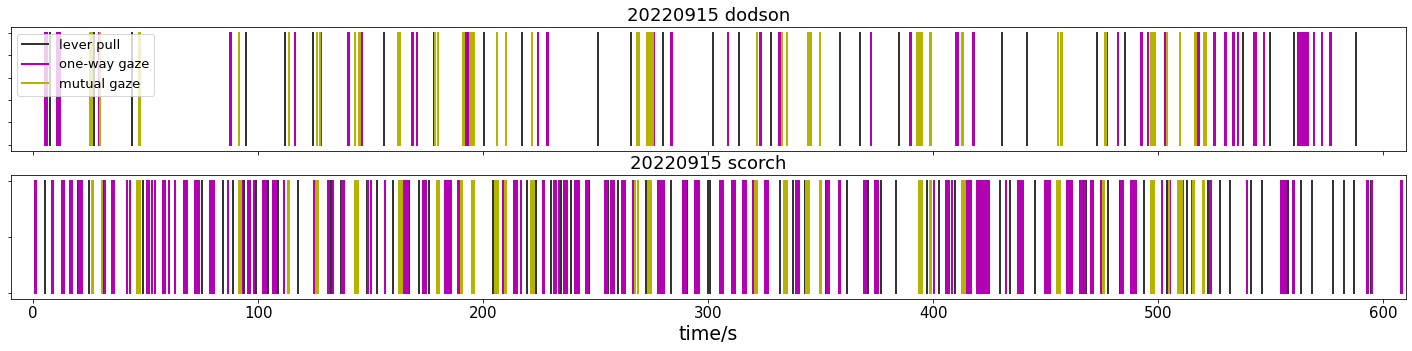

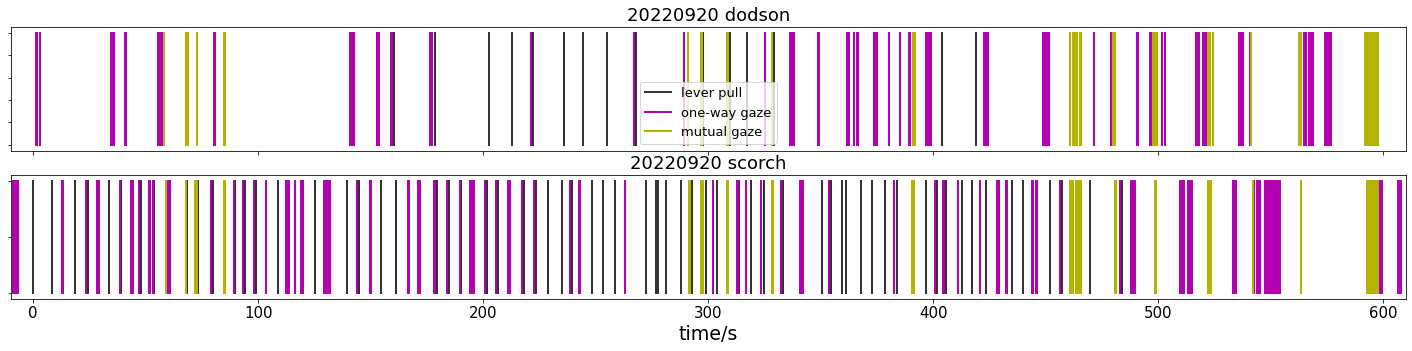

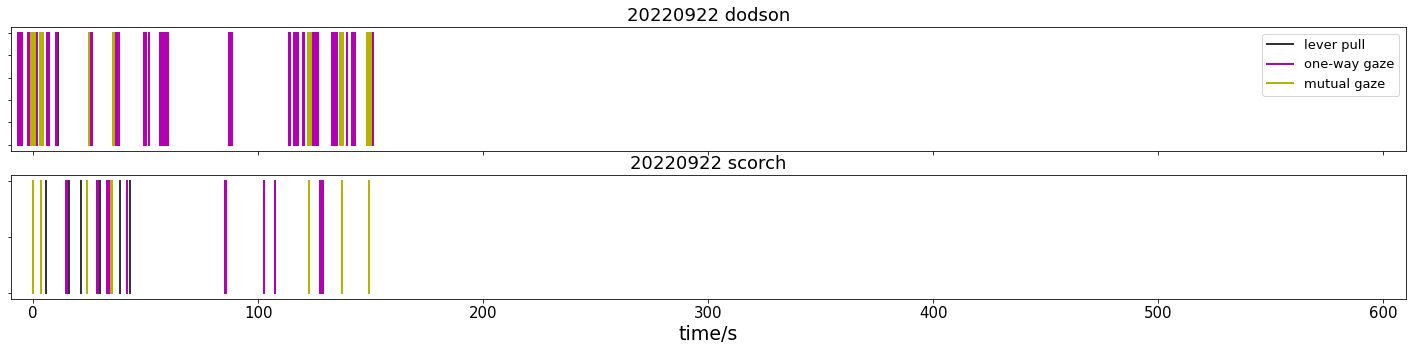

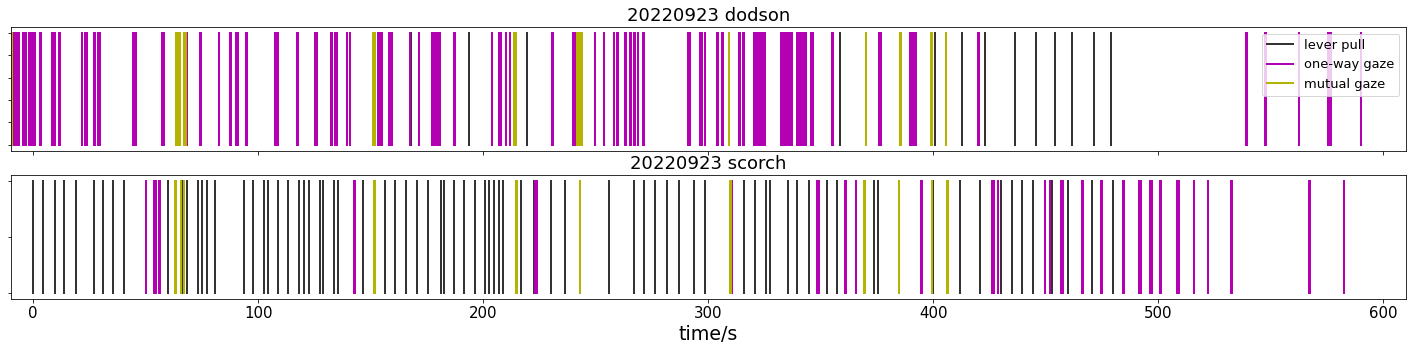

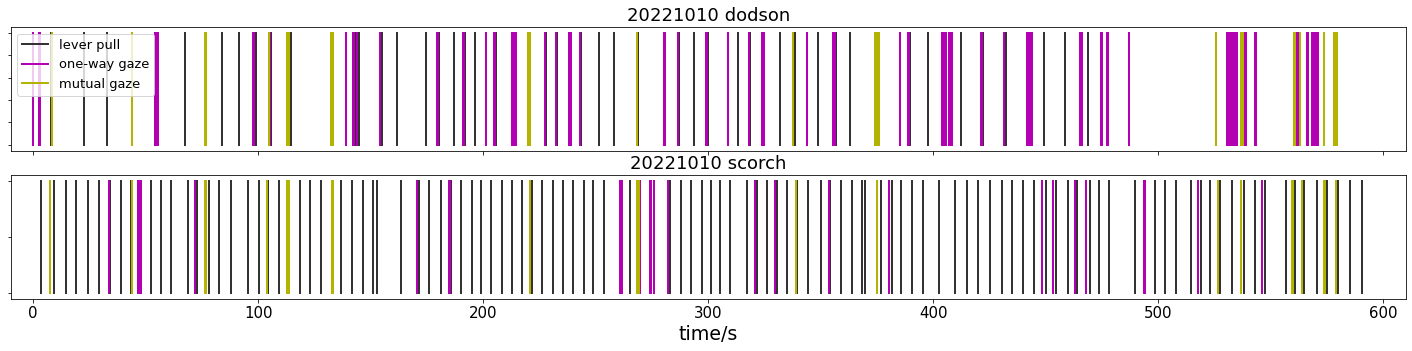

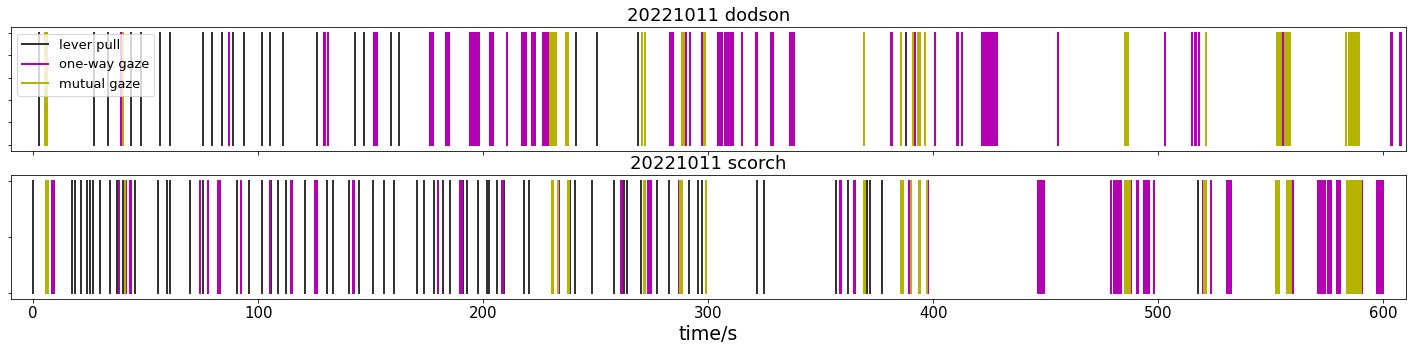

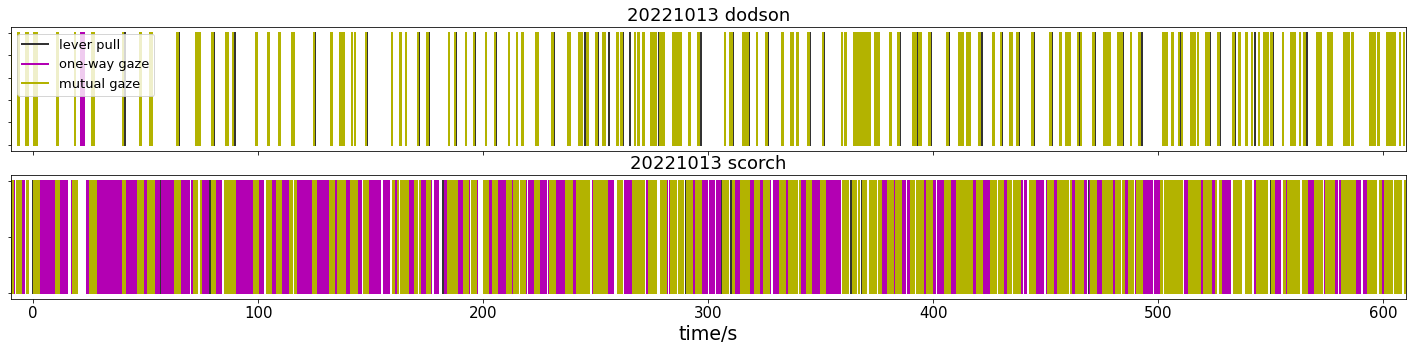

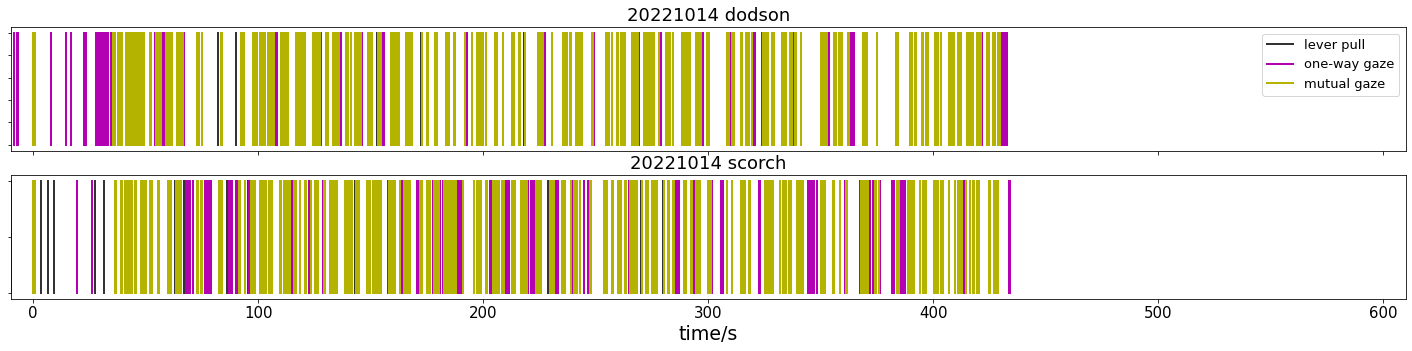

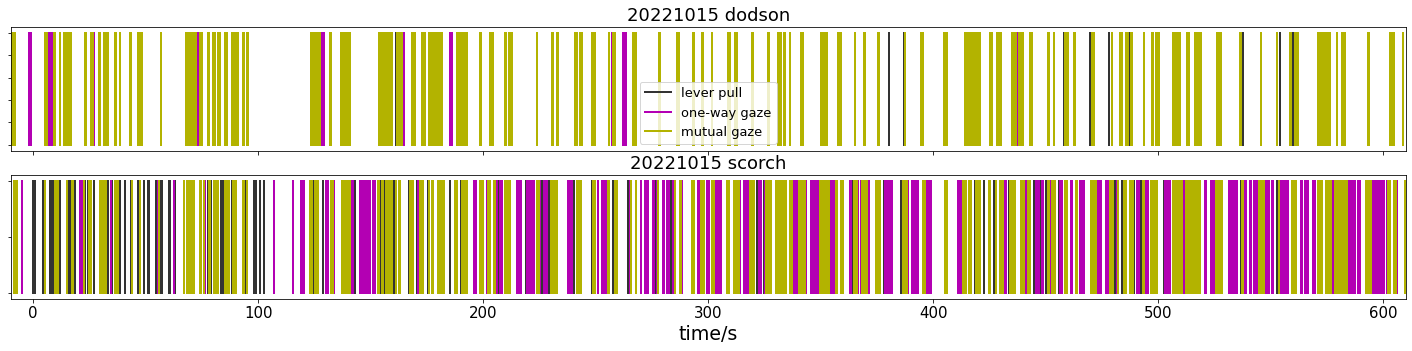

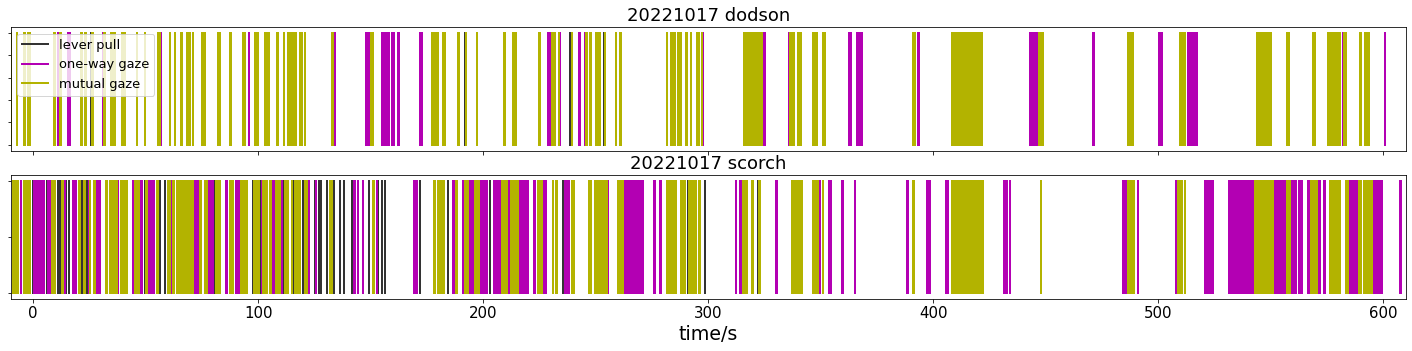

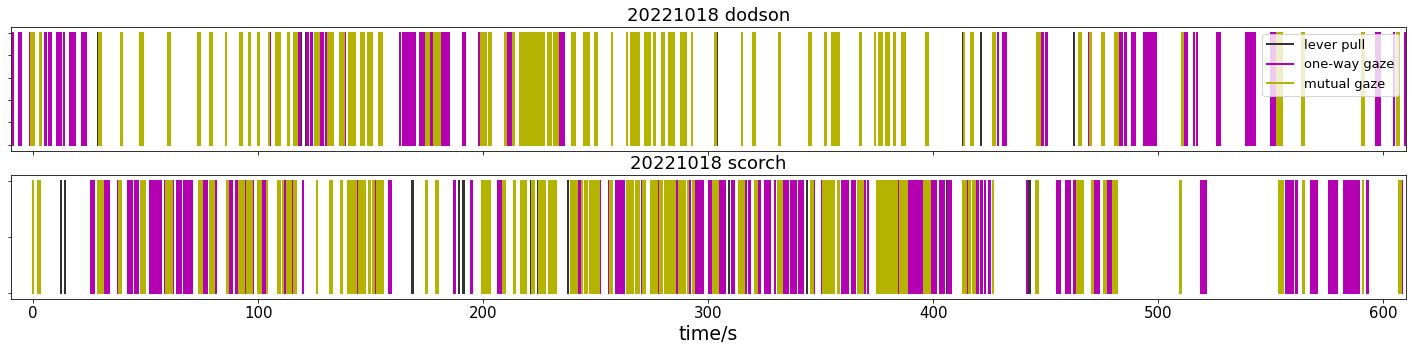

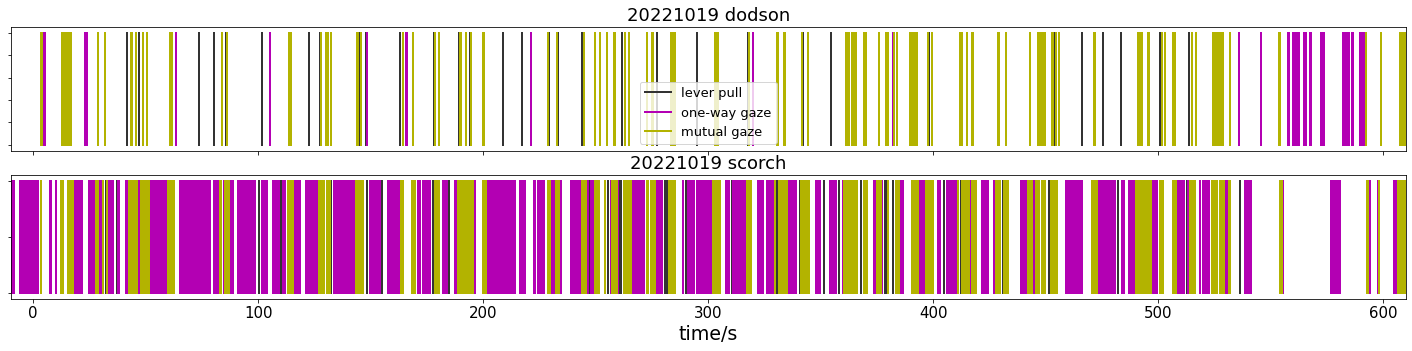

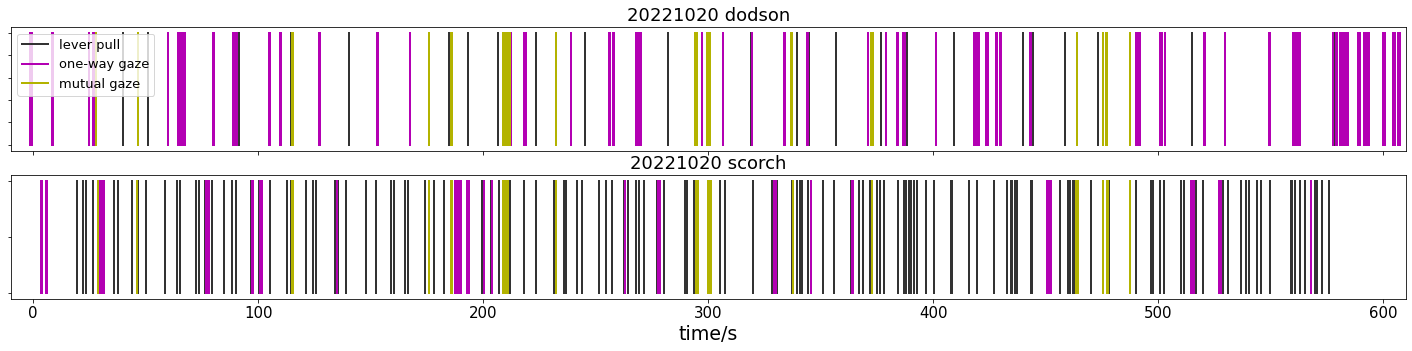

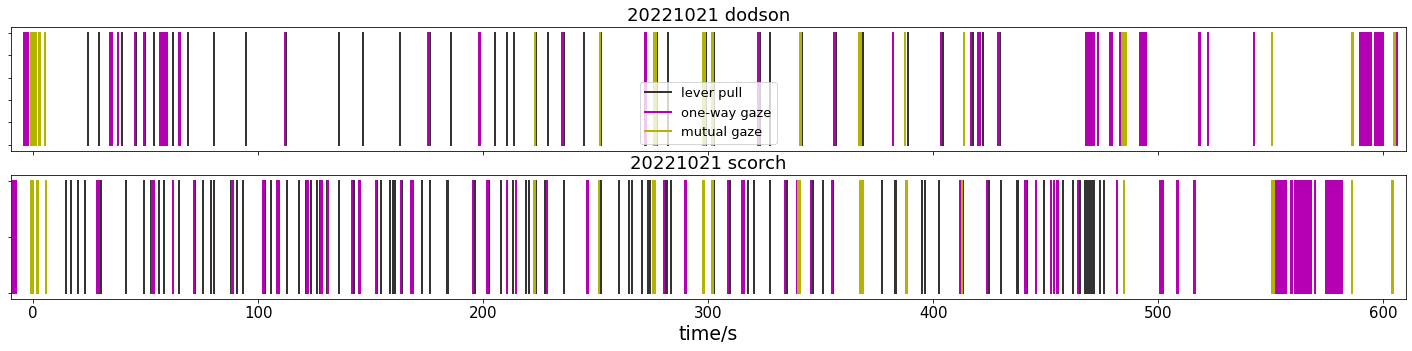

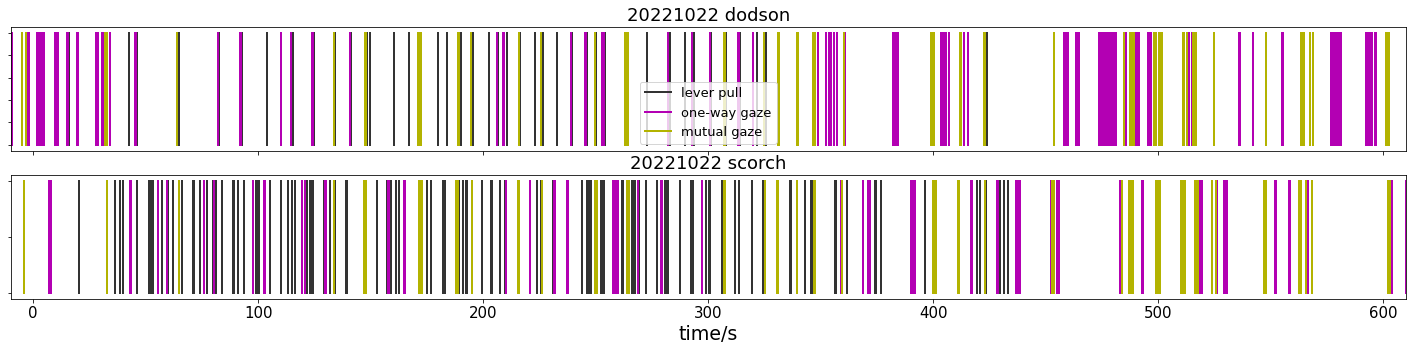

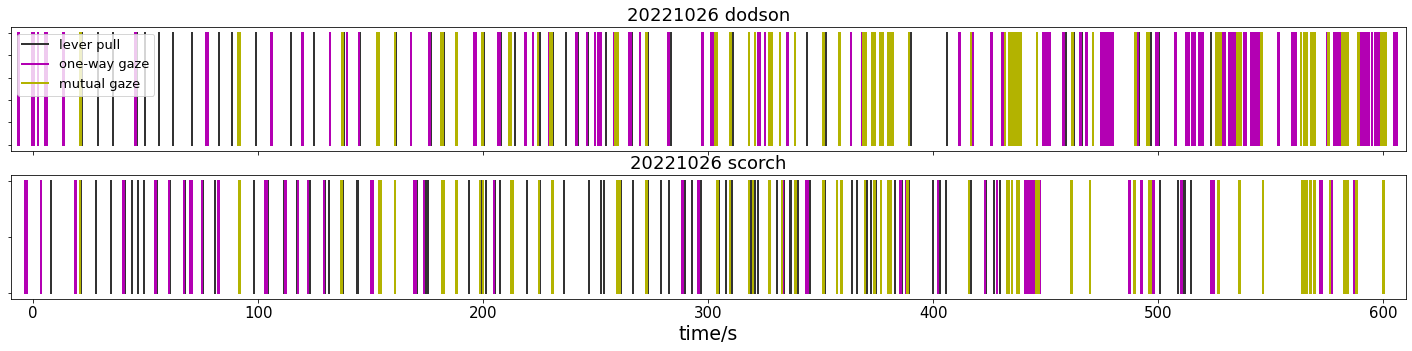

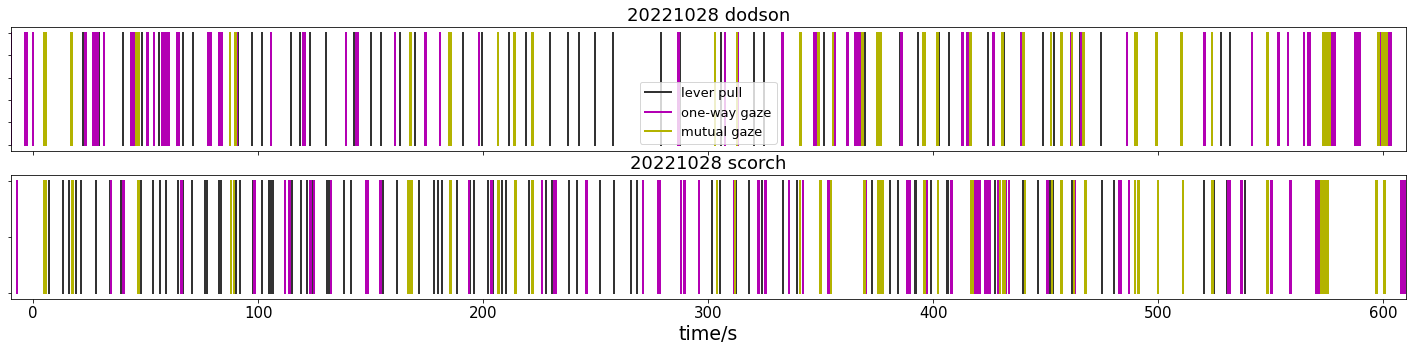

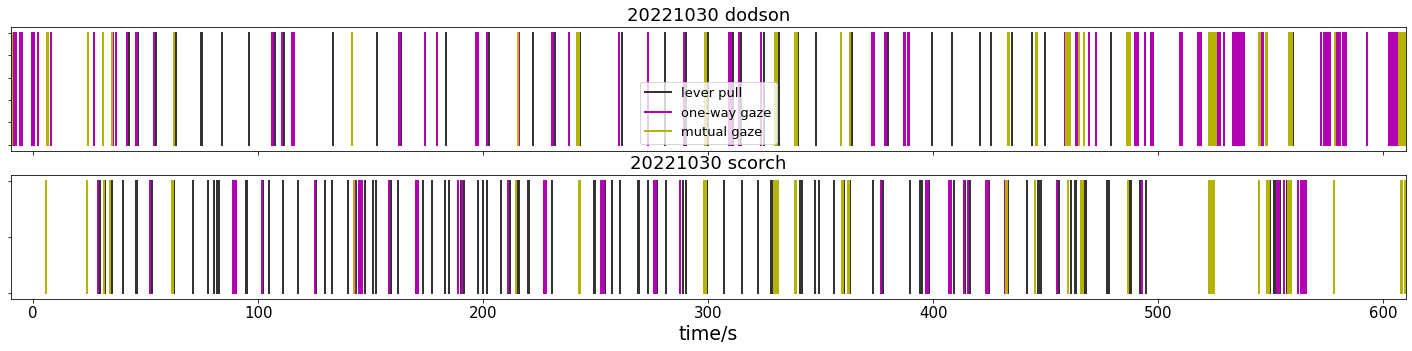

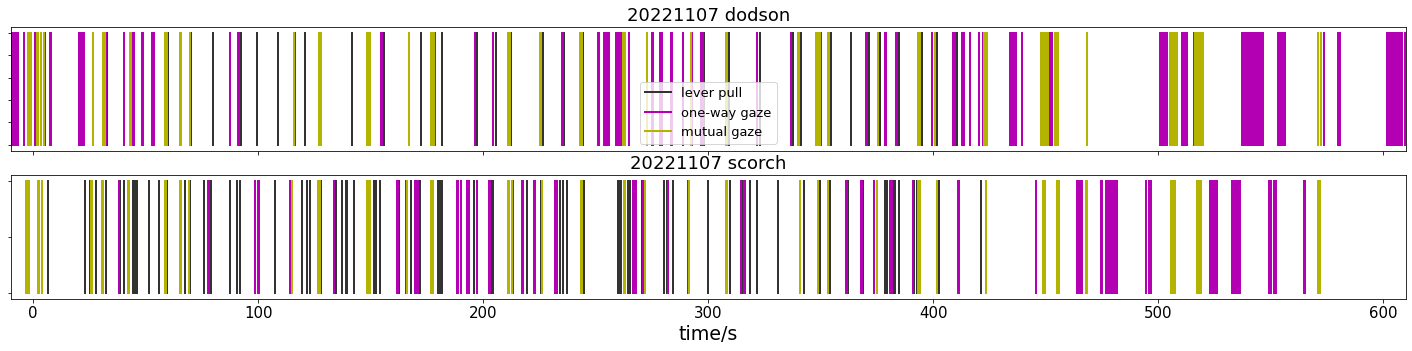

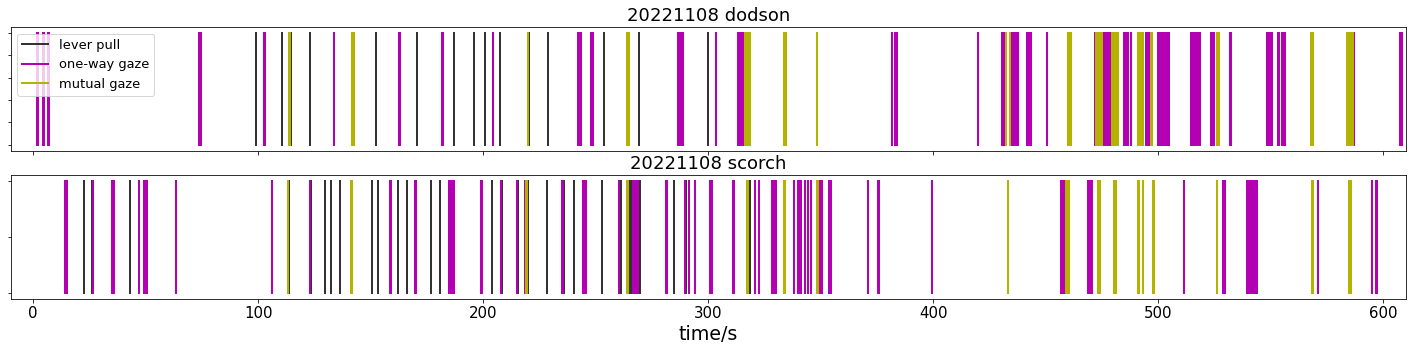

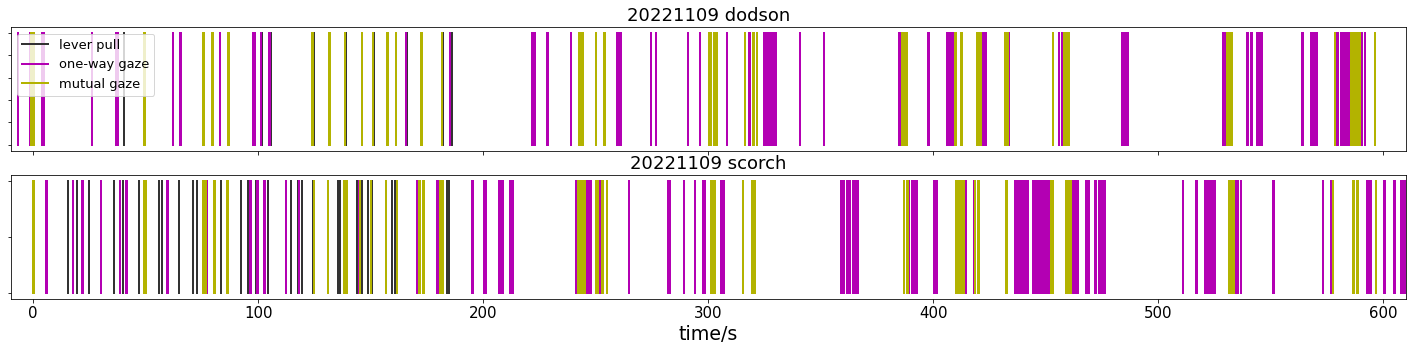

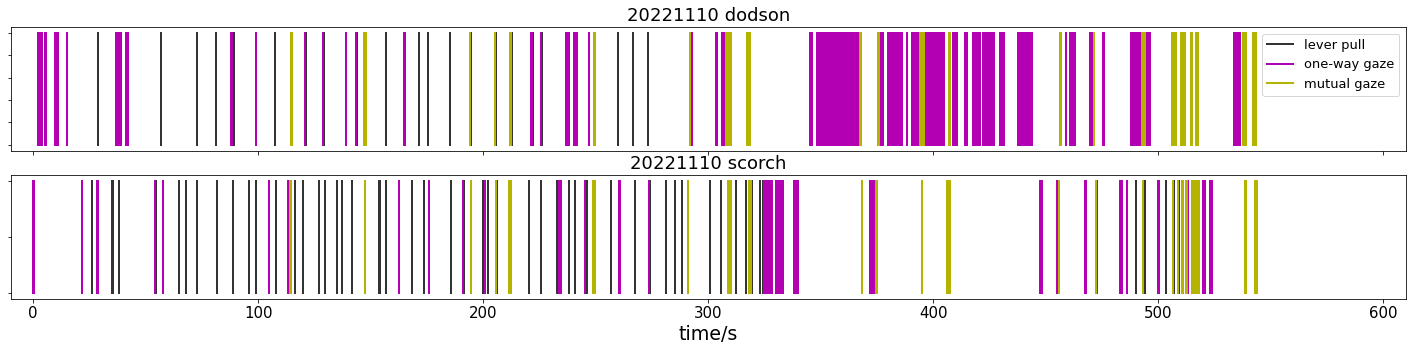

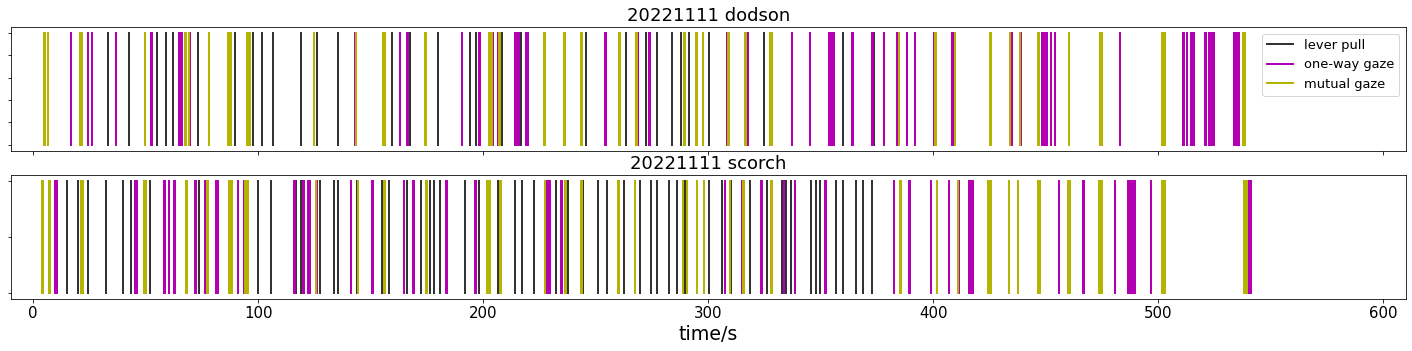

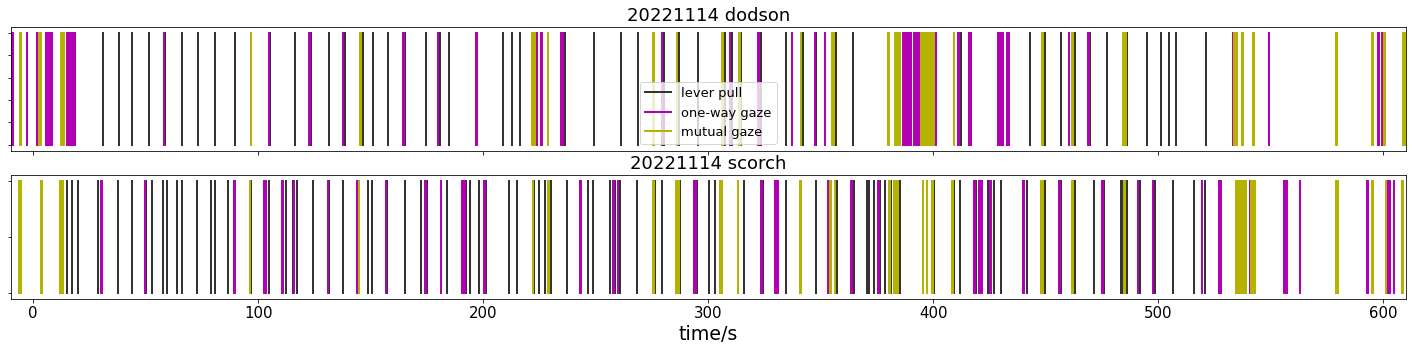

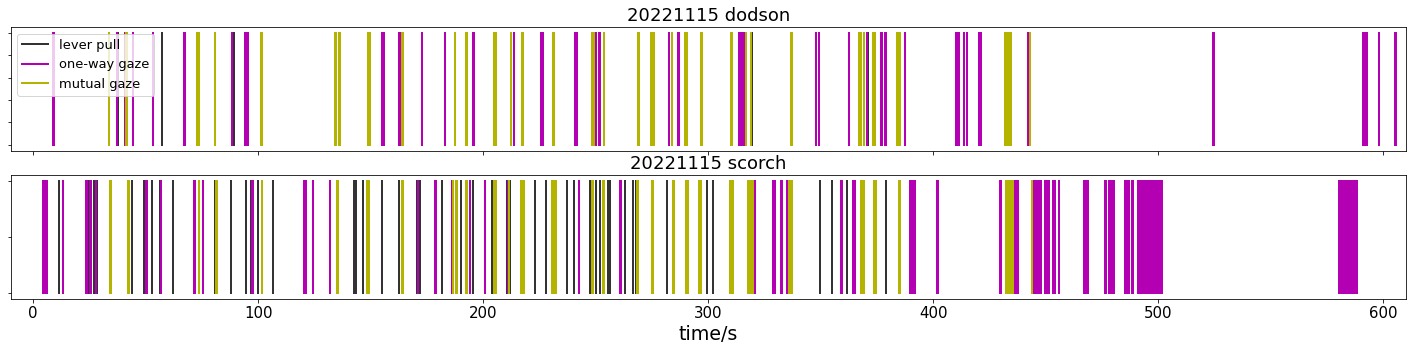

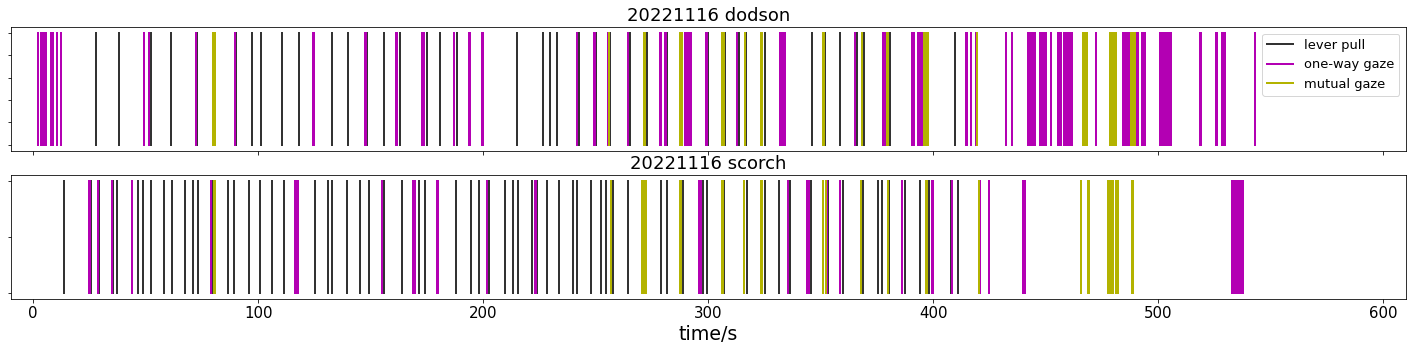

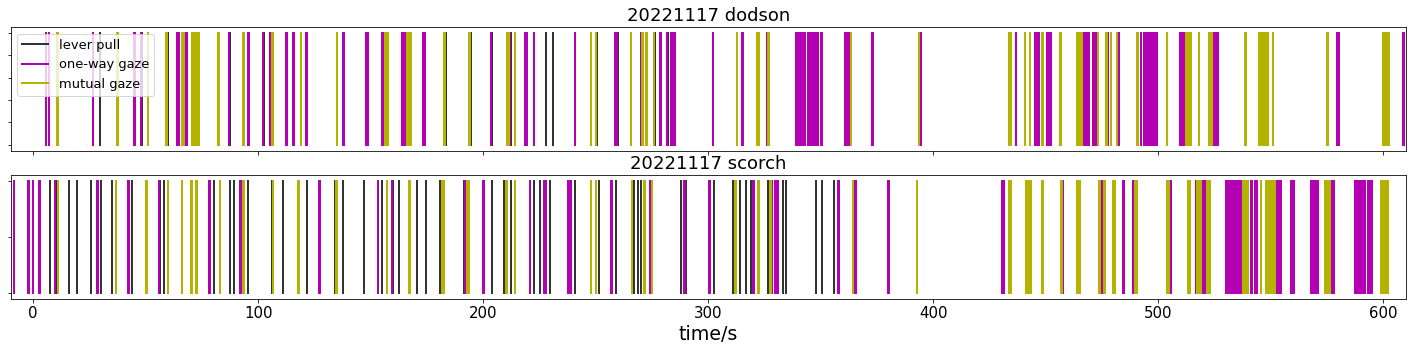

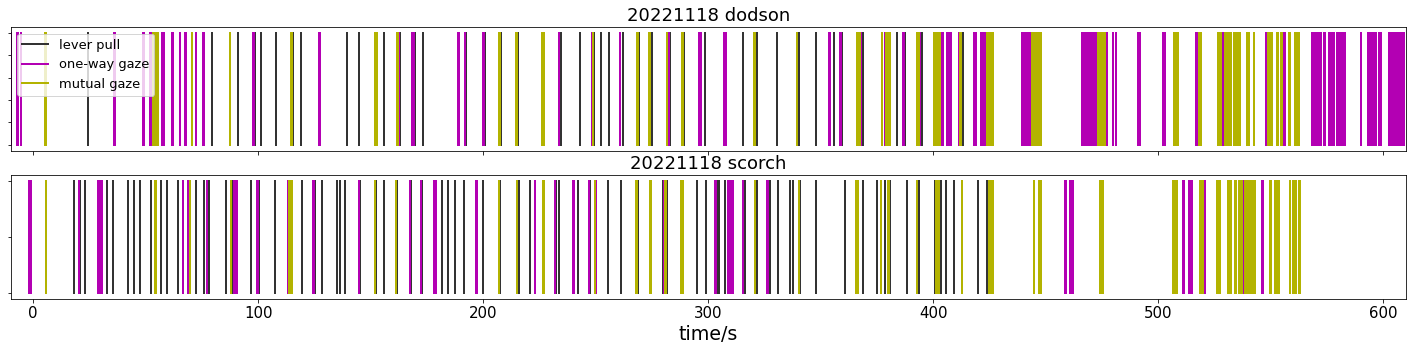

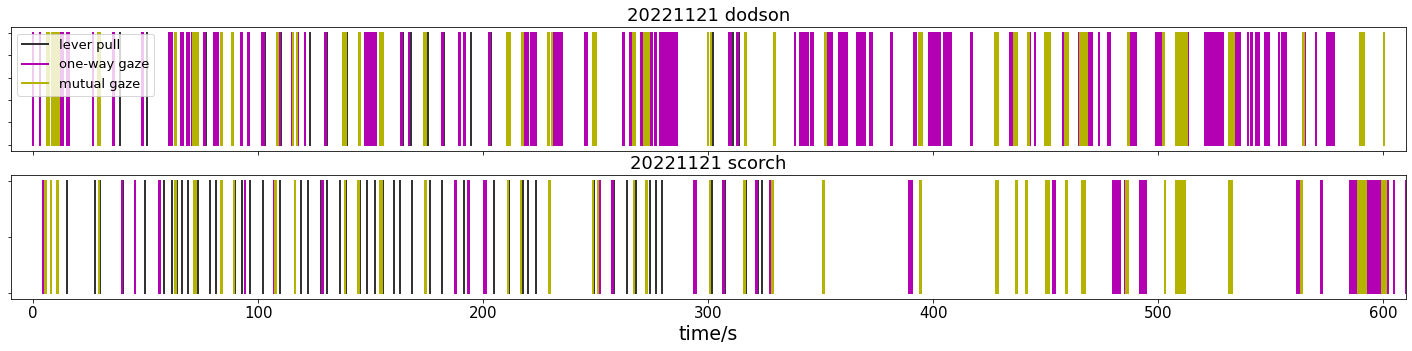

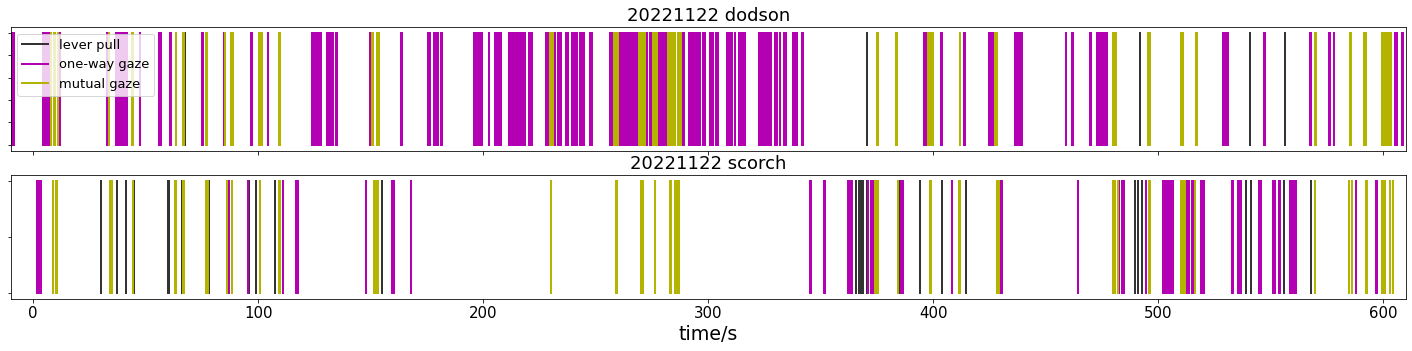

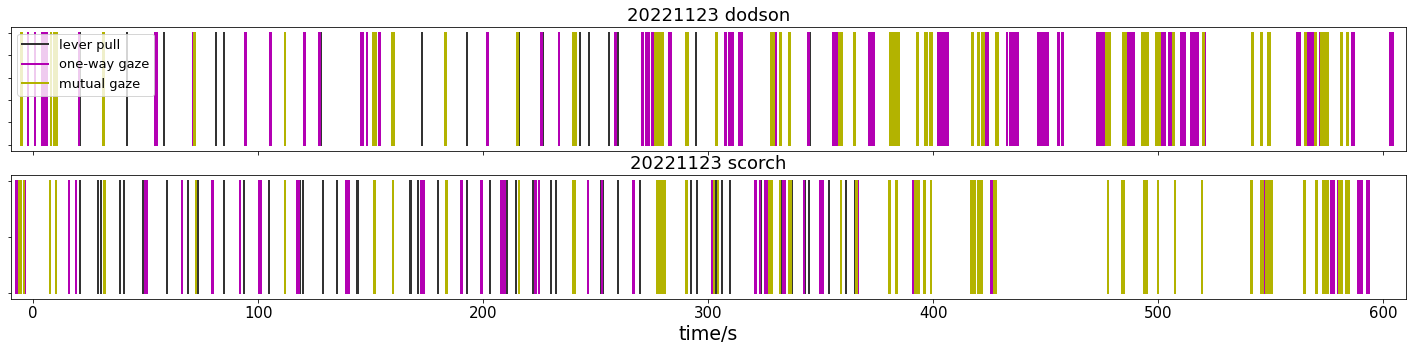

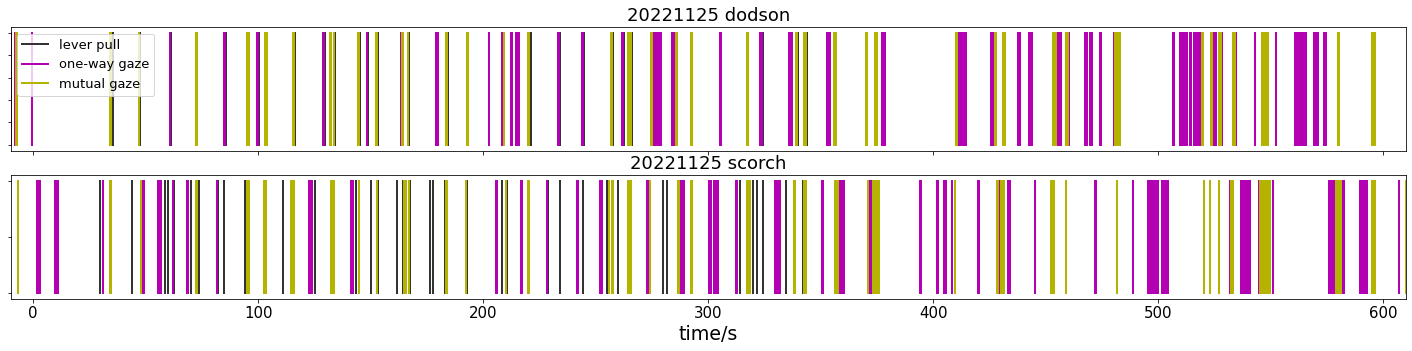

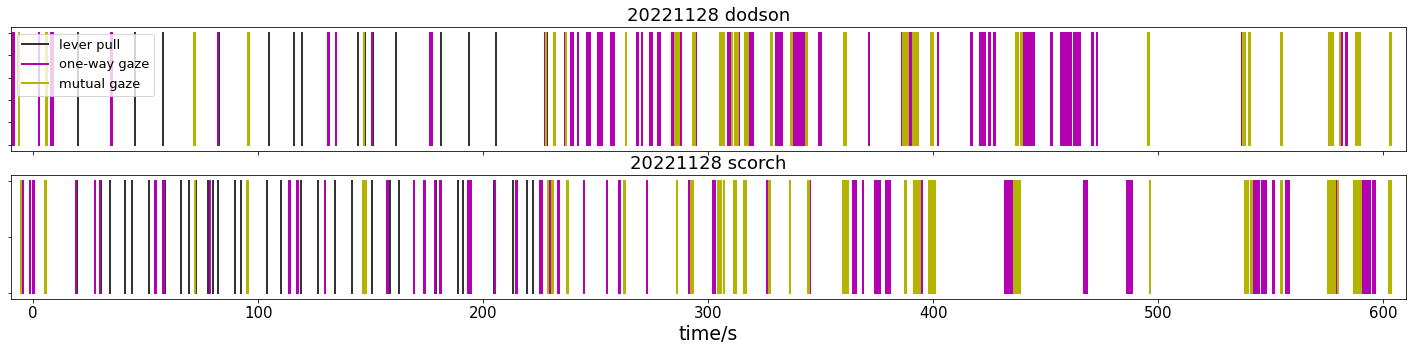

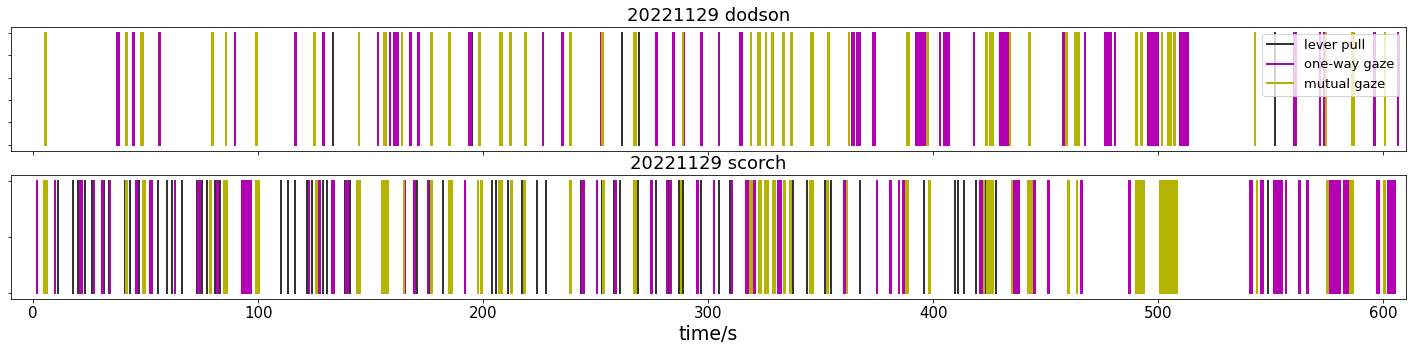

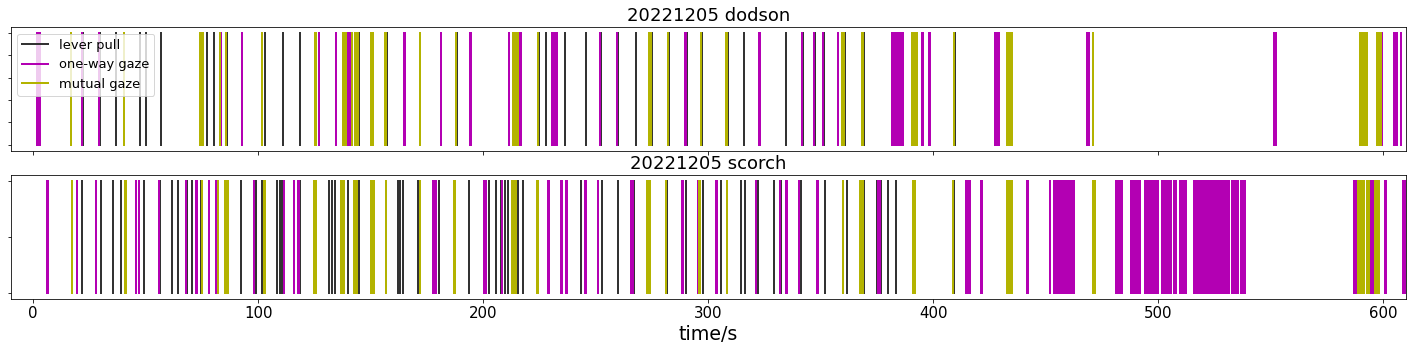

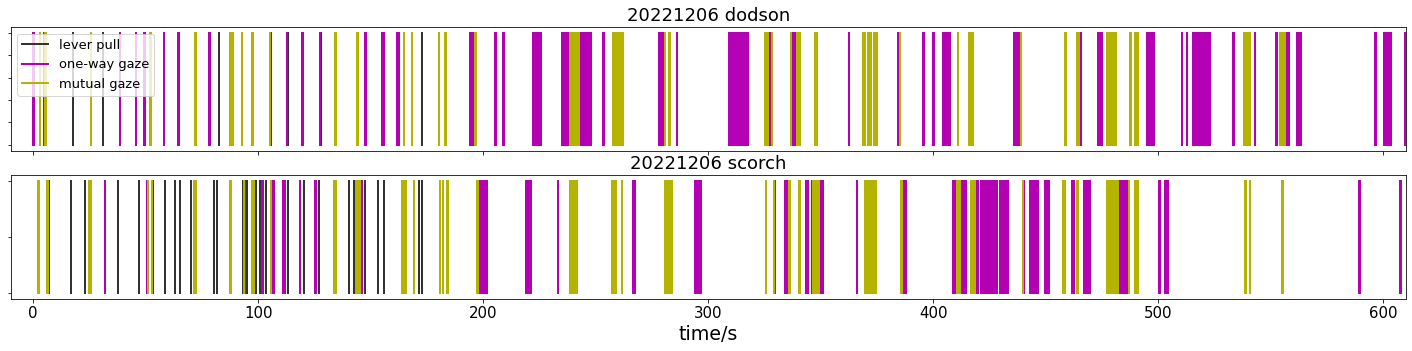

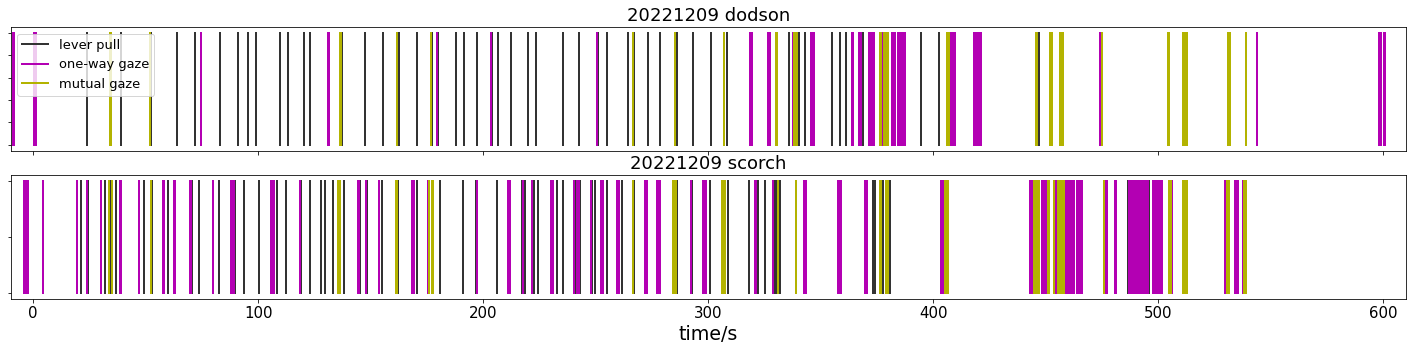

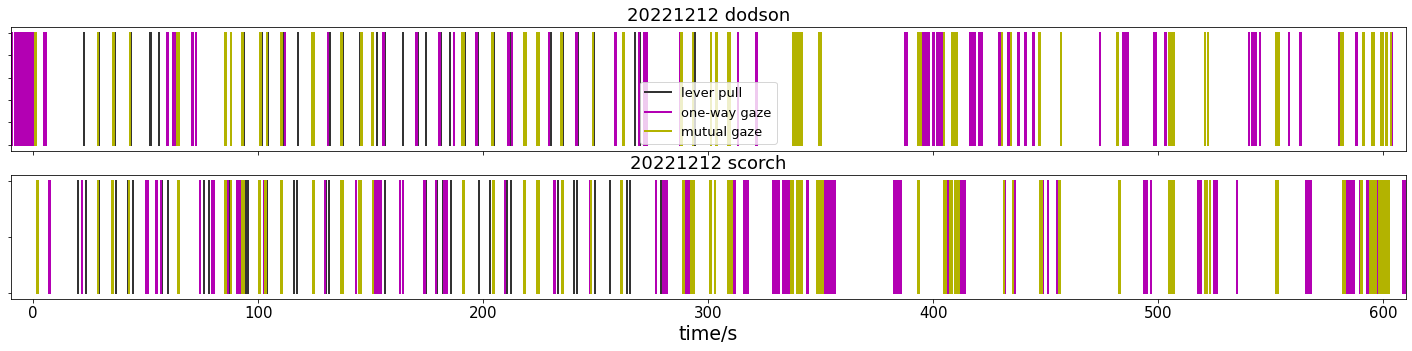

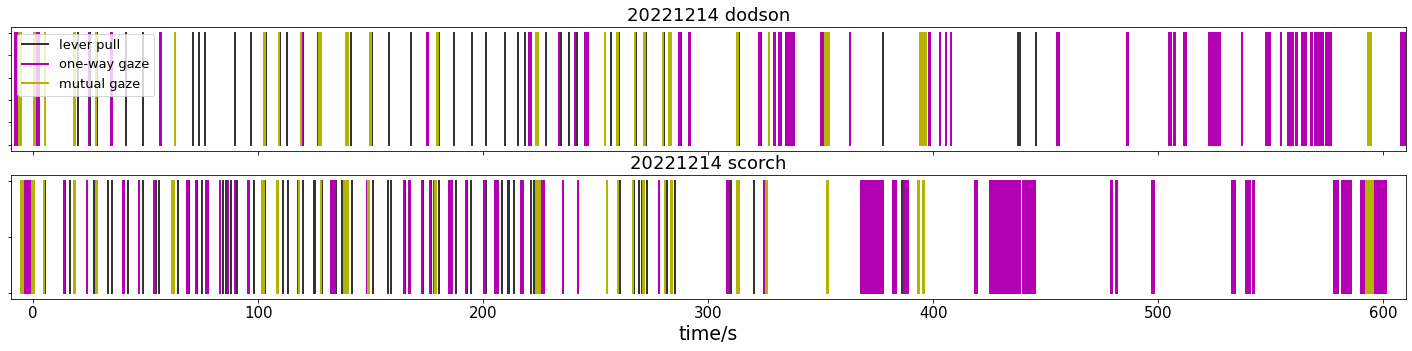

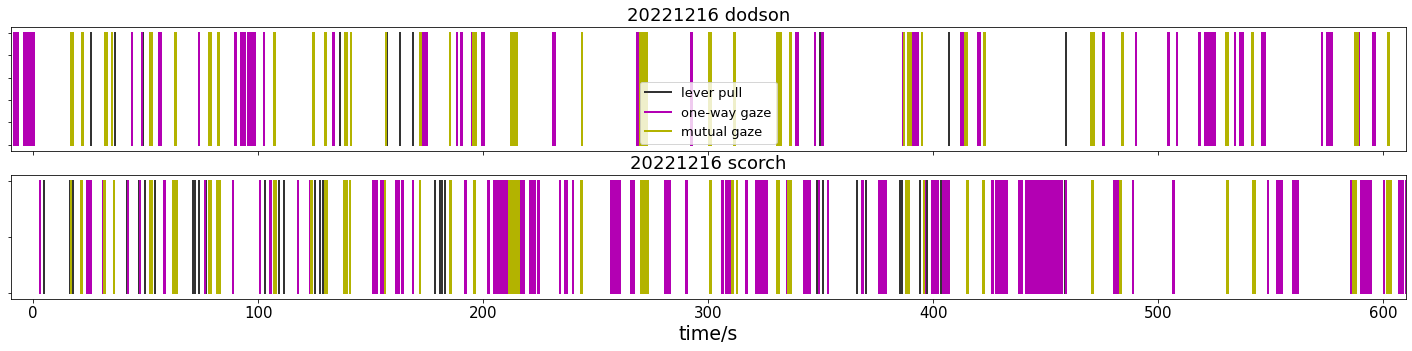

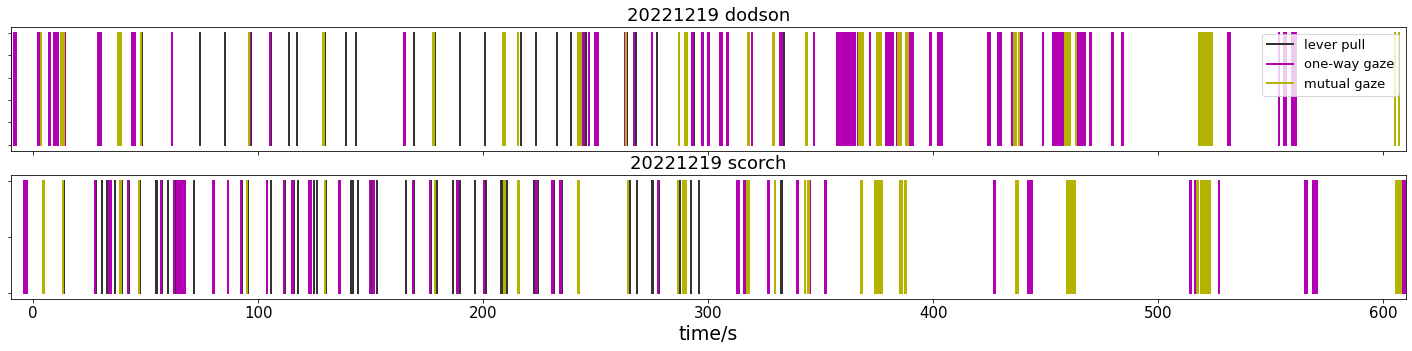

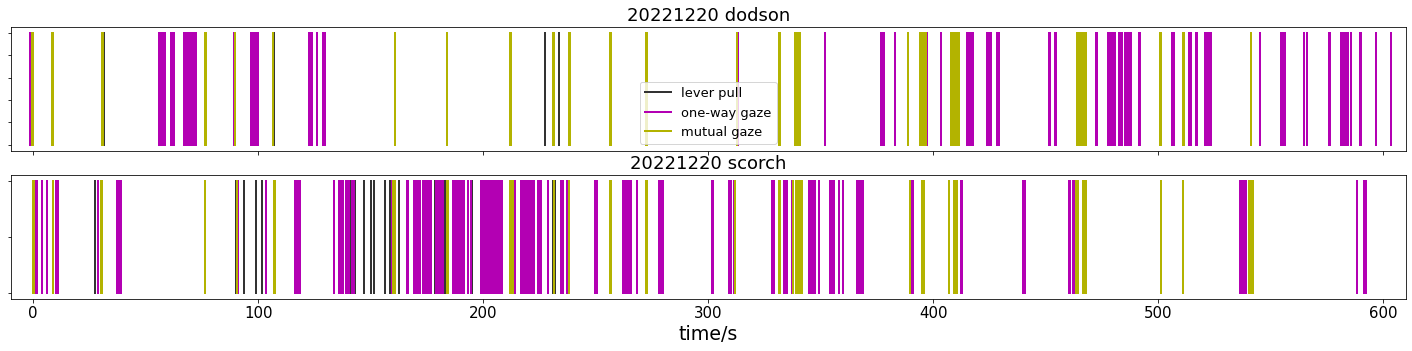

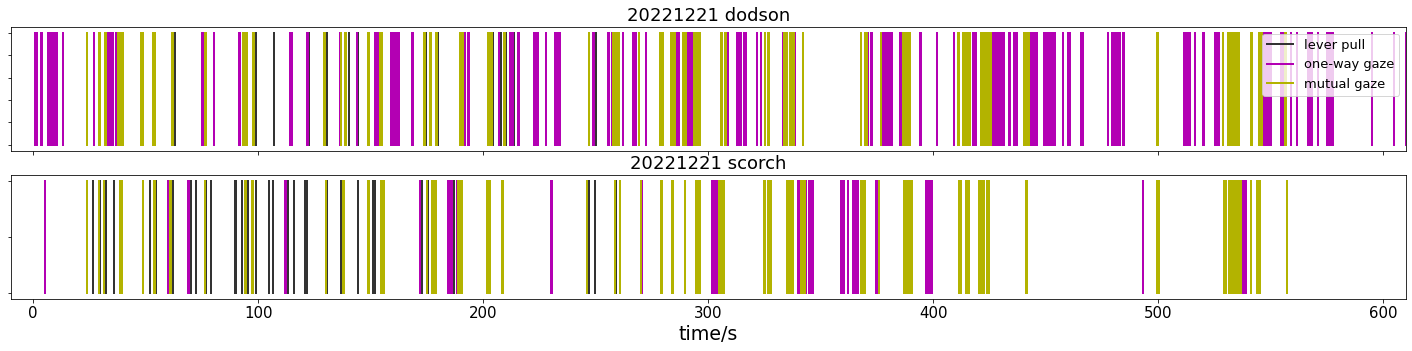

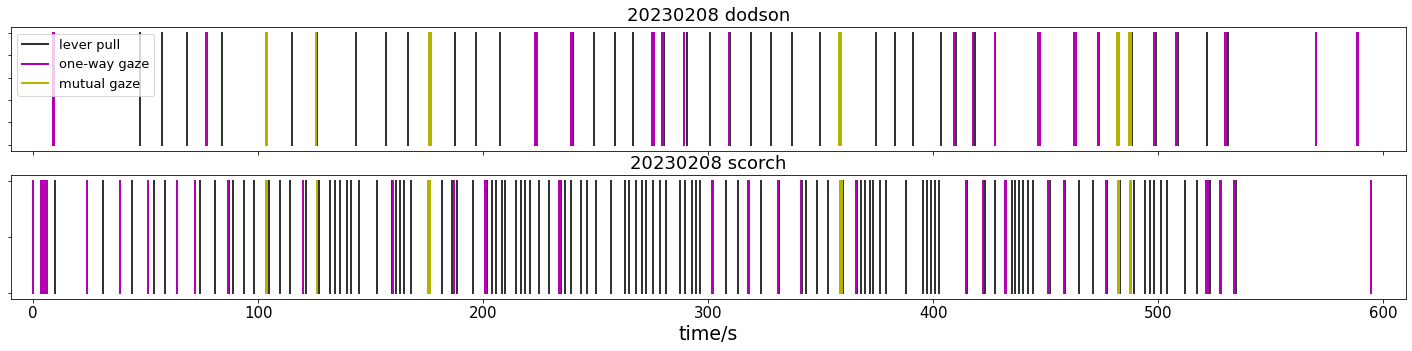

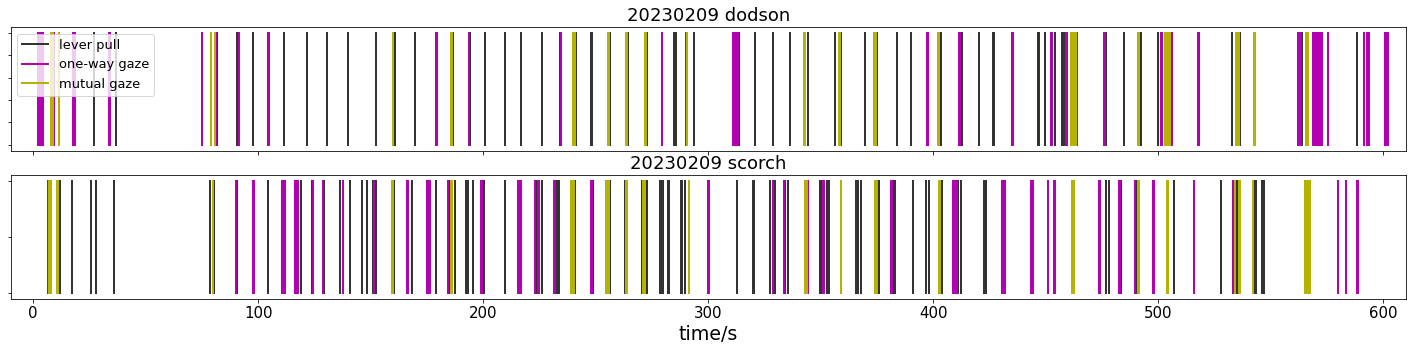

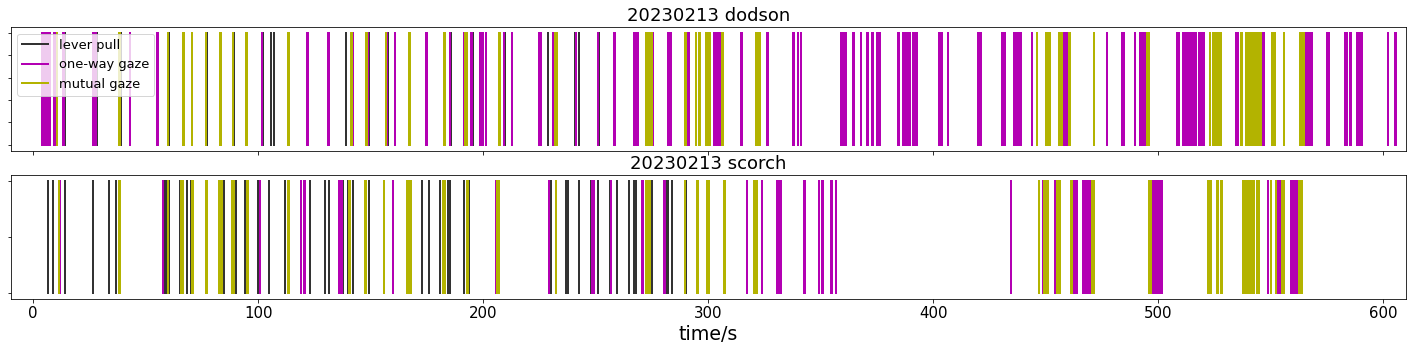

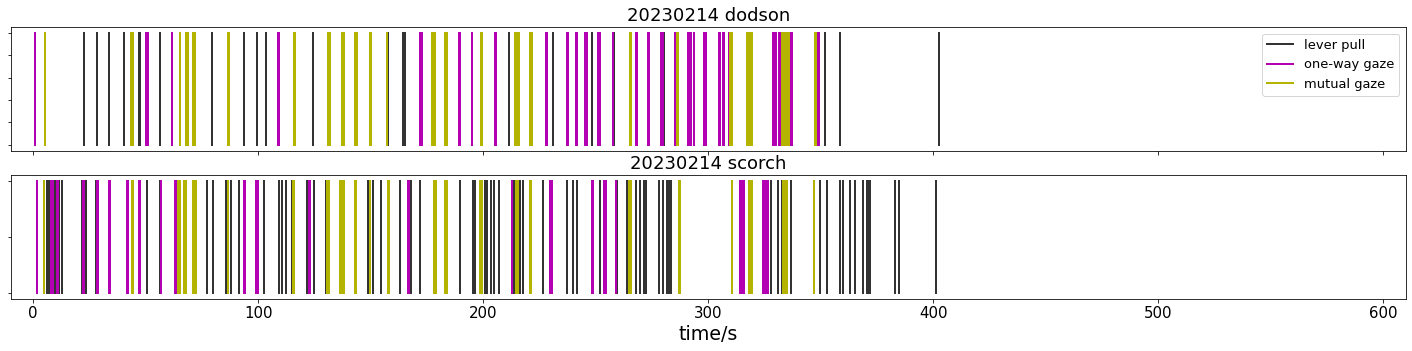

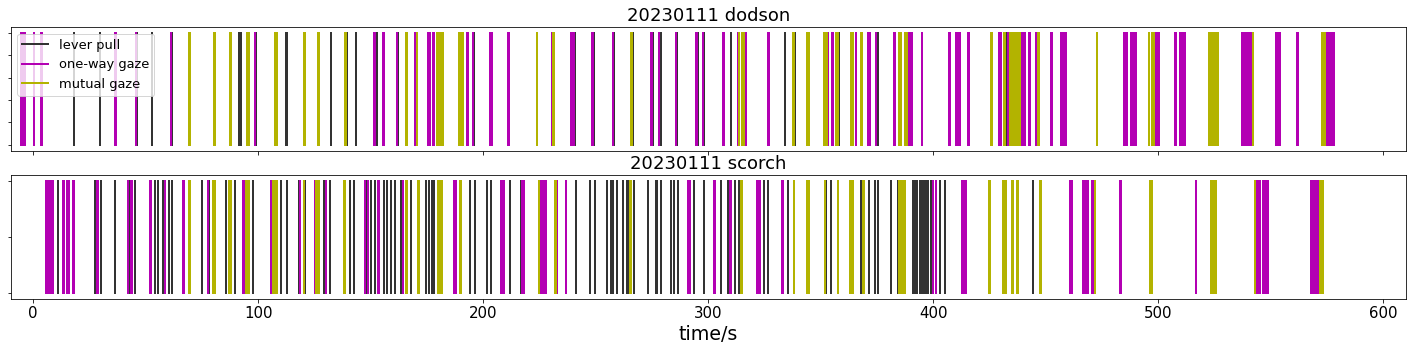

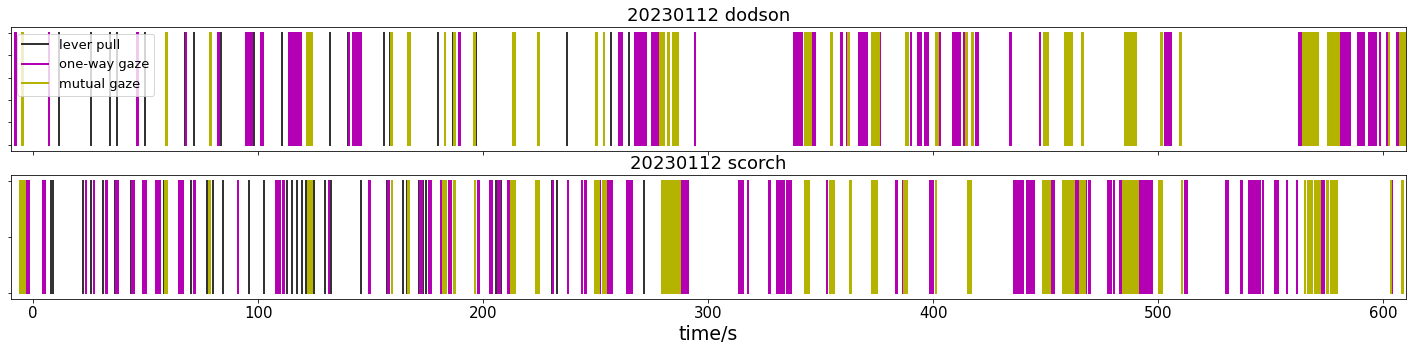

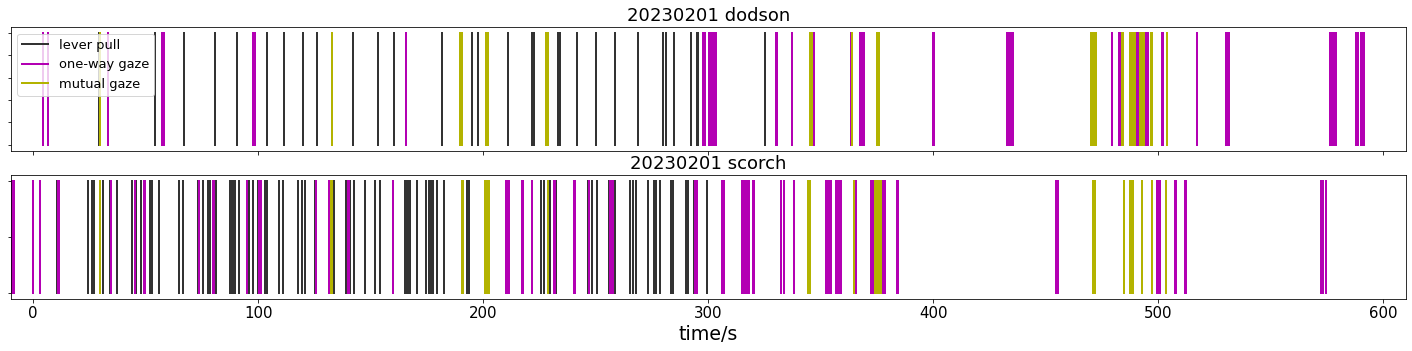

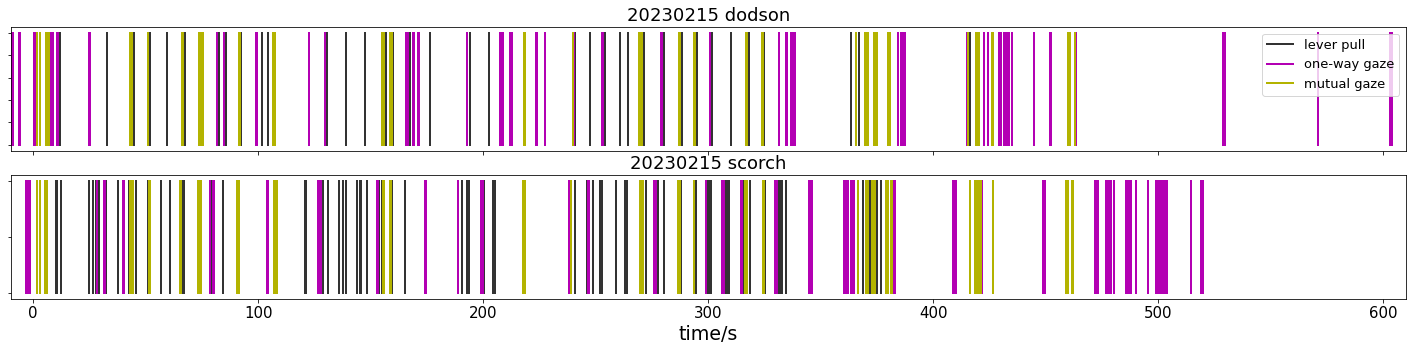

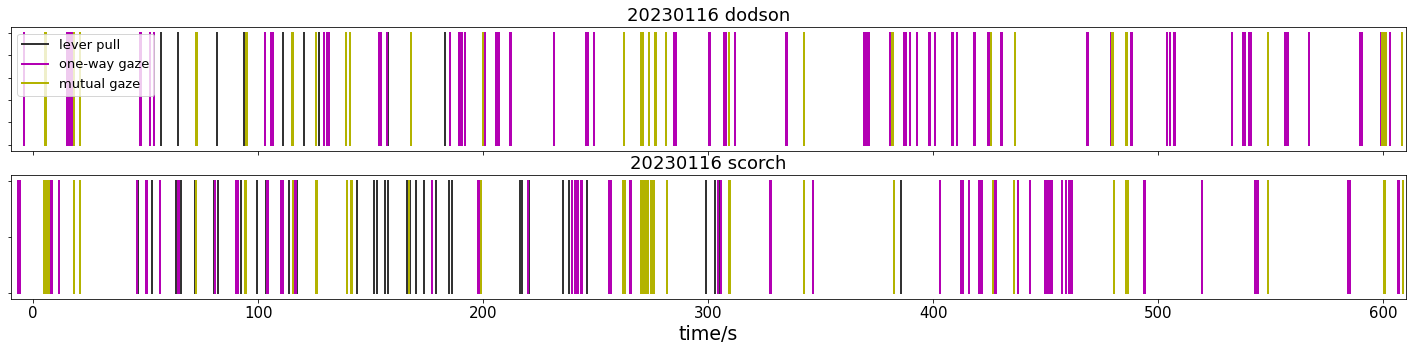

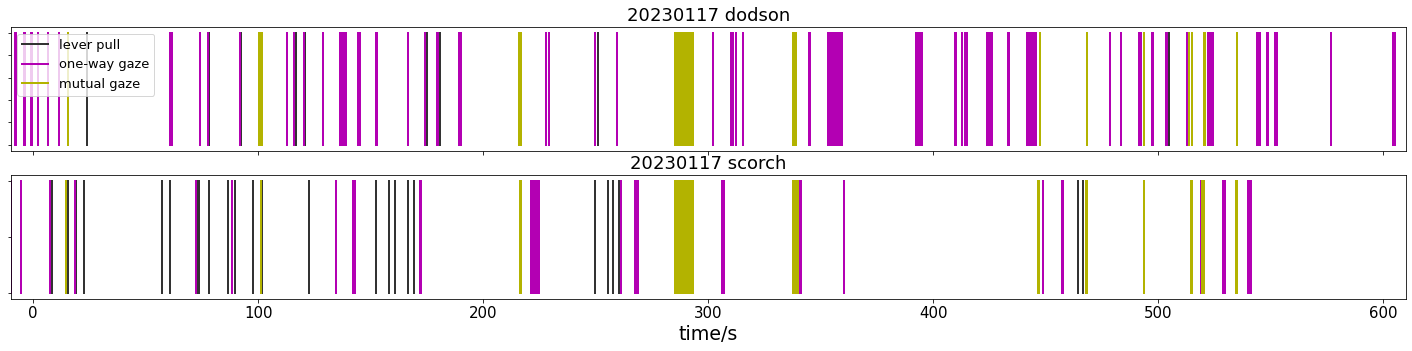

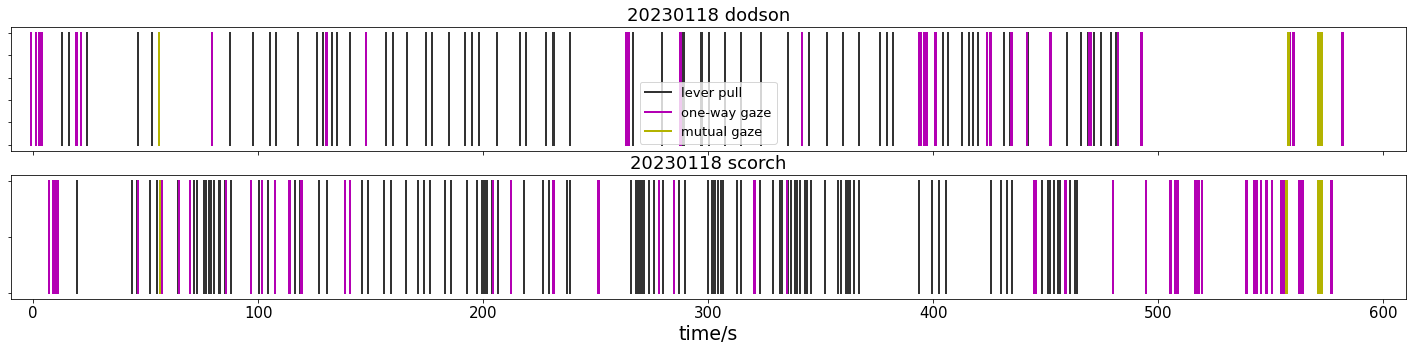

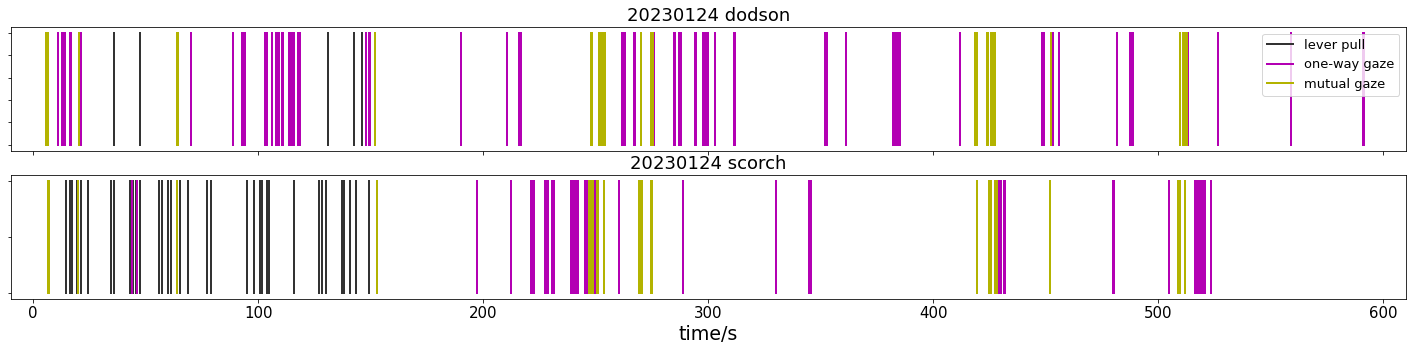

In [16]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
nframes = 25*30

# re-analyze the video or not
reanalyze_video = 0

# all the videos (no misaligned ones)
# dodson scorch
if 1:
    dates_list = [
                  "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                  "20221011","20221013","20221014","20221015","20221017",
                  "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                  "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",

                  "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                  "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220","20221221",
                  "20230208","20230209","20230213","20230214","20230111","20230112","20230201","20230215",
                  "20230116","20230117","20230118","20230124"         
                 ]
# eddie sparkle
if 0:
    dates_list = [
                  "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                  "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                  "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                  "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                  "20230321","20230322","20230324","20230327","20230328",
                  "20230330","20230331","20230403","20230404","20230405",
                  "20230406","20230407"
               ]
# ginger kanga
if 0:
    dates_list = [
                  "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                  "20230303","20230307","20230314","20230315","20230316","20230317","20230320","20230322",
                  "20230323","20230327","20230328","20230330","20230331","20230405","20230406","20230410",
                  "20230412","20230413"
               ]
#    
# dates_list = ["20230112","20230201","20230215","20230116","20230117","20230118","20230124"]

ndates = np.shape(dates_list)[0]

# dodson scorch
if 1:
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 0:
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# all the videos (no misaligned ones)
# dodson scorch 
if 1:
    session_start_times = [ 
                             6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                             2.80, 27.80, 272.50, 27.90, 27.00,
                            28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                            15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 

                            75.50, 20.20,  0.00, 24.20,  36.70, 26.40, 22.50, 28.50,                       
                             0.00,  0.00, 21.70, 84.70,  17.00, 19.80, 23.50, 25.20,  0.00,
                             0.00,  0.00,  0.00,  0.00, 130.00, 14.20, 24.20, 33.00,
                            28.80, 67.40, 67.00, 24.80                            
                          ] # in second
# eddie sparkle
if 0:
    session_start_times = [ 
                             8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                             4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                             7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                             8.00,8.00,4.00,123.00,14.00,8.80,
                             7.00,7.50,5.50,11.00,9.00,
                             17.00,4.50,9.30,25.50,20.40,
                             21.30,24.80
                          ] # in second 
# ginger kanga
if 0:
    session_start_times = [ 
                             0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                            34.00, 25.50, 25.50, 31.50, 28.00, 30.50, 22.20, 29.00,
                            33.00, 32.50, 36.50, 24.20, 32.70, 22.00, 20.00, 32.20,
                            18.20, 22.80
                          ] # in second  
#  
# session_start_times = [14.20, 24.20, 33.00,28.80, 67.40, 67.00, 24.80] # in second

session_start_frames = session_start_times * fps # fps is 30Hz


# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
DAGs_all_dates = np.zeros((ndates,4,4))
DAGs_thres_dates = np.zeros((ndates,4,4))
ntempres_dates = np.zeros((ndates,1,1))
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))


try:
    dummy
    
    # load saved data
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_thres_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        ntempres_dates = pickle.load(f)

    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_1.json"
            bhv_data_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_1.json"
            session_info_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_1.json"
            #
            trial_record = pd.read_json(trial_record_json)
            bhv_data = pd.read_json(bhv_data_json)
            session_info = pd.read_json(session_info_json)
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_1.json"
            bhv_data_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_1.json"
            session_info_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_1.json"
            #
            trial_record = pd.read_json(trial_record_json)
            bhv_data = pd.read_json(bhv_data_json)
            session_info = pd.read_json(session_info_json)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = os.getcwd()+'/bhv_events_singlecam_wholebody_'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            
        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = os.getcwd()+'/bhv_events_singlecam_wholebody_'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig("bhv_events_singlecam_wholebody_"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        
        # plot the tracking demo video
        if 0: 
            if np.isin(animal1,animal1_fixedorder):
                tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)
            else:
                tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull2,time_point_pull1,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)
        
        

        # # plot inter-pull interval
        # plot_interpull_interval(animal1, animal2, time_point_pull1, time_point_pull2)

        # # train the dynamic bayesian network - simple model
        # temp_resolu = 0.5 # temporala resolution in the DBN model 0.5 means 500ms
        # model = train_DBN(totalsess_time,temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        # plot the simple DBN
        # pos=nx.spring_layout(model)
        # nx.draw(model,pos,with_labels = True)
        # labels = nx.get_edge_attributes(model,'weight')
        # nx.draw_networkx_edge_labels(model,pos,edge_labels=labels
        # model.get_cpds()

        # # train the dynamic bayesian network - Alec's model
        # temp_resolu = 2 # temporal resolution in the DBN model, eg: 0.5 means 500ms
        # totalsess_time = 660 # total session time in s
        # best_model, edges, DAGs,_,_,_ = train_DBN_alec(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)

        # # train the dynamic bayesian network - Alec's model for separate "trials"
        # temp_resolu = 2 # temporala resolution in the DBN model 0.5 means 500ms
        # totalsess_time = 600 # total session time in s
        # DAGs_itrial, weighted_graphs,_,_,_ = train_DBN_alec_eachtrial(totalsess_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        
        
        # # train the dynamic bayesian network - Alec's model, try different time step
        if 0:
            print('DBN analysis for '+date_tgt)
            # use bhv event to decide temporal resolution
            totalsess_time = 600 # total session time in s
            low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            # temp_resolus  = np.arange(low_lim,up_lim,0.1)
            # temp_resolus = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            temp_resolus = np.arange(0.1,1.1,0.1)
            
            ntemp_reses = np.shape(temp_resolus)[0]

            DAGs_all_tempres = np.zeros([4,4])
            for temp_resolu in temp_resolus:
                if np.isin(animal1,animal1_fixedorder):
                    best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                else:
                    best_model,edges,DAGs,eventnames,from_pops,to_pops = train_DBN_alec(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     
                print(edges)
                DAGs[0][np.isnan(DAGs[0])]=0
                DAGs_all_tempres = DAGs_all_tempres + DAGs[0]

            DAGs_all_tempres = DAGs_all_tempres/ntemp_reses
            DAGs_thres_tempres = np.zeros([4,4])
            DAGs_thres_tempres[DAGs_all_tempres>0.5]=1
            #
            DAGs_all_dates[idate,:,:]= DAGs_all_tempres
            DAGs_thres_dates[idate,:,:] = DAGs_thres_tempres
            ntempres_dates[idate,:,:] = ntemp_reses
            #
            # edge_list = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
            # ind_edges = np.reshape(np.transpose(np.mean(DAGs_thres_dates,axis=0)>0.15),(16,1))
            # edges_good = [edge_list[i] for i in np.where(ind_edges)[0]]


# save data
if 0:
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(DAGs_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(DAGs_thres_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(ntempres_dates, f)

    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(owgaze1_num_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(owgaze2_num_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(mtgaze1_num_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(mtgaze2_num_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(pull1_num_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(pull2_num_all_dates, f)

    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(tasktypes_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(coopthres_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(succ_rate_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(interpullintv_all_dates, f)
    with open('data_saved_original_singlecam_wholebody/'+cameraID+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        pickle.dump(trialnum_all_dates, f)

    

### plot the transition probability from social gaze to pull

In [40]:
coopthres_all_dates[tasktypes_all_dates==1] = 0

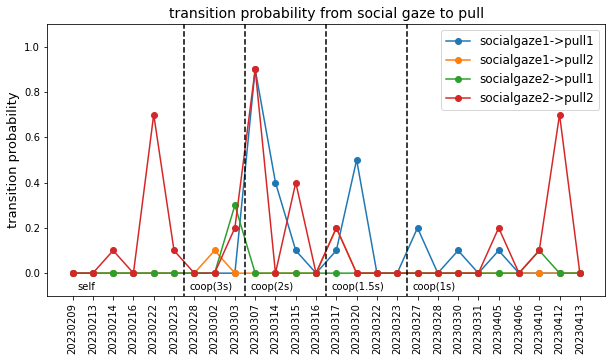

In [41]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type, coorpthre and dates
# coopthres_forsort = (tasktypes_all_dates)*coopthres_all_dates/2
# coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
# sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
# sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
sorting_df = pd.DataFrame({'dates':dates_list,'tasktype':tasktypes_all_dates.ravel(),
                           'coopthres':coopthres_all_dates.ravel()}, columns=['dates','tasktype','coopthres'])
sorting_df = sorting_df.sort_values(by=['tasktype','coopthres','dates'], ascending = [True,False,True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,2,0],'o-',label = "socialgaze1->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,2,1],'o-',label = "socialgaze1->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,3,0],'o-',label = "socialgaze2->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,3,1],'o-',label = "socialgaze2->pull2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where((np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)|
                        (np.array(sorting_df['tasktype'])[1:]-np.array(sorting_df['tasktype'])[:-1]!=0))[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

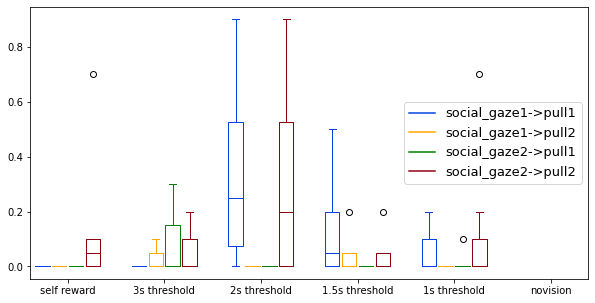

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold', 'novision']

gaze1_pull1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],2,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],2,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],2,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],2,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],2,0],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],2,0]
              ]
gaze1_pull2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],2,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],2,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],2,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],2,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],2,1],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],2,1]
              ]
gaze2_pull1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],3,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],3,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],3,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],3,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],3,0],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],3,0]
              ]
gaze2_pull2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],3,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],3,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],3,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],3,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],3,1],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],3,1]
              ]
gaze1_pull1_plot = plt.boxplot(gaze1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
gaze1_pull2_plot = plt.boxplot(gaze1_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
gaze2_pull1_plot = plt.boxplot(gaze2_pull1,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
gaze2_pull2_plot = plt.boxplot(gaze2_pull2,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_pull1_plot, '#0343DF', 'social_gaze1->pull1')
define_box_properties(gaze1_pull2_plot, '#FFA500', 'social_gaze1->pull2')
define_box_properties(gaze2_pull1_plot, '#008000', 'social_gaze2->pull1')
define_box_properties(gaze2_pull2_plot, '#8C000F', 'social_gaze2->pull2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to social gaze

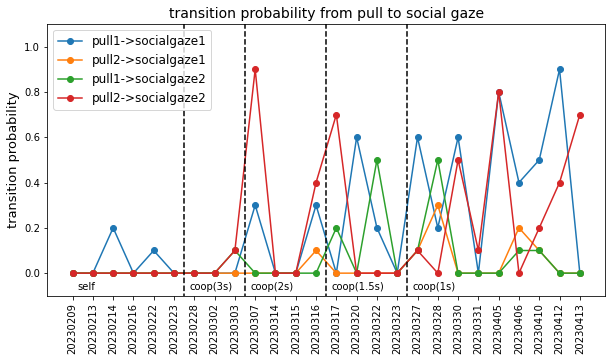

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates':dates_list,'tasktype':tasktypes_all_dates.ravel(),
                           'coopthres':coopthres_all_dates.ravel()}, columns=['dates','tasktype','coopthres'])
sorting_df = sorting_df.sort_values(by=['tasktype','coopthres','dates'], ascending = [True,False,True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,2],'o-',label = "pull1->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,1,2],'o-',label = "pull2->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,0,3],'o-',label = "pull1->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,1,3],'o-',label = "pull2->socialgaze2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where((np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)|
                        (np.array(sorting_df['tasktype'])[1:]-np.array(sorting_df['tasktype'])[:-1]!=0))[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

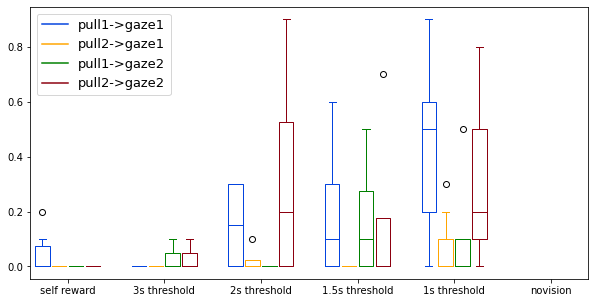

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

pull1_gaze1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],0,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],0,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],0,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],0,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],0,2],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],0,2]
              ]
pull2_gaze1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],1,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],1,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],1,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],1,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],1,2],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],1,2]
              ]
pull1_gaze2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],0,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],0,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],0,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],0,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],0,3],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],0,3]
              ]
pull2_gaze2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],1,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],1,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],1,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],1,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],1,3],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],1,3] 
              ]
pull1_gaze1_plot = plt.boxplot(pull1_gaze1,positions=np.array(np.arange(len(pull1_gaze1)))*4.0-1.05,widths=0.6)
pull2_gaze1_plot = plt.boxplot(pull2_gaze1,positions=np.array(np.arange(len(pull2_gaze1)))*4.0-0.35,widths=0.6)
pull1_gaze2_plot = plt.boxplot(pull1_gaze2,positions=np.array(np.arange(len(pull1_gaze2)))*4.0+0.35,widths=0.6)
pull2_gaze2_plot = plt.boxplot(pull2_gaze2,positions=np.array(np.arange(len(pull2_gaze2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_gaze1_plot, '#0343DF', 'pull1->gaze1')
define_box_properties(pull2_gaze1_plot, '#FFA500', 'pull2->gaze1')
define_box_properties(pull1_gaze2_plot, '#008000', 'pull1->gaze2')
define_box_properties(pull2_gaze2_plot, '#8C000F', 'pull2->gaze2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to pull

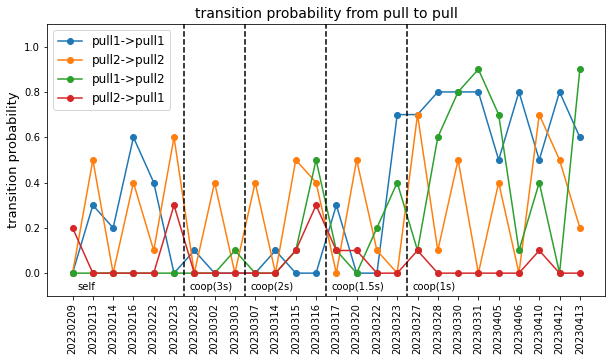

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates':dates_list,'tasktype':tasktypes_all_dates.ravel(),
                           'coopthres':coopthres_all_dates.ravel()}, columns=['dates','tasktype','coopthres'])
sorting_df = sorting_df.sort_values(by=['tasktype','coopthres','dates'], ascending = [True,False,True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,0],'o-',label = "pull1->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,1,1],'o-',label = "pull2->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,0,1],'o-',label = "pull1->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,1,0],'o-',label = "pull2->pull1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where((np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)|
                        (np.array(sorting_df['tasktype'])[1:]-np.array(sorting_df['tasktype'])[:-1]!=0))[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

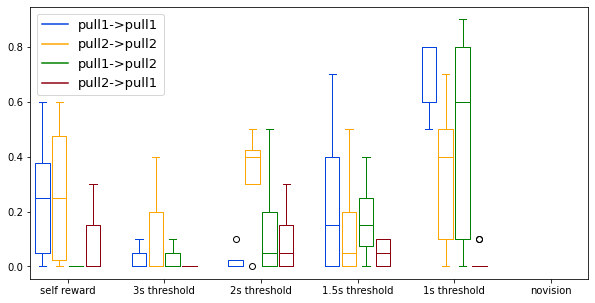

In [46]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

pull1_pull1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],0,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],0,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],0,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],0,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],0,0],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],0,0]
              ]
pull2_pull2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],1,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],1,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],1,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],1,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],1,1],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],1,1]
              ]
pull1_pull2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],0,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],0,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],0,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],0,1],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],0,1],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],0,1]
              ]
pull2_pull1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],1,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],1,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],1,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],1,0],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],1,0],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],1,0]
              ]
pull1_pull1_plot = plt.boxplot(pull1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
pull2_pull2_plot = plt.boxplot(pull2_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
pull1_pull2_plot = plt.boxplot(pull1_pull2,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
pull2_pull1_plot = plt.boxplot(pull2_pull1,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_pull1_plot, '#0343DF', 'pull1->pull1')
define_box_properties(pull2_pull2_plot, '#FFA500', 'pull2->pull2')
define_box_properties(pull1_pull2_plot, '#008000', 'pull1->pull2')
define_box_properties(pull2_pull1_plot, '#8C000F', 'pull2->pull1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from social gaze to social gaze

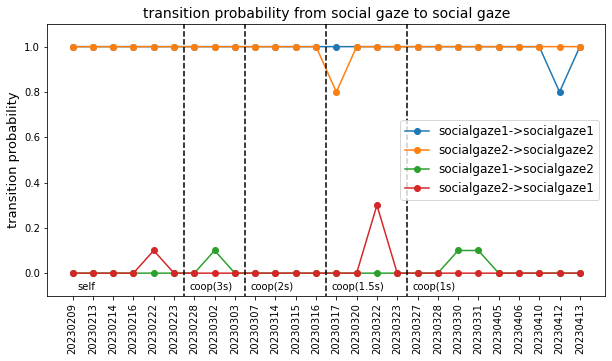

In [47]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates':dates_list,'tasktype':tasktypes_all_dates.ravel(),
                           'coopthres':coopthres_all_dates.ravel()}, columns=['dates','tasktype','coopthres'])
sorting_df = sorting_df.sort_values(by=['tasktype','coopthres','dates'], ascending = [True,False,True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,2,2],'o-',label = "socialgaze1->socialgaze1")
ax1.plot(DAGs_all_dates[sorting_df.index,3,3],'o-',label = "socialgaze2->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,2,3],'o-',label = "socialgaze1->socialgaze2")
ax1.plot(DAGs_all_dates[sorting_df.index,3,2],'o-',label = "socialgaze2->socialgaze1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where((np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)|
                        (np.array(sorting_df['tasktype'])[1:]-np.array(sorting_df['tasktype'])[:-1]!=0))[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

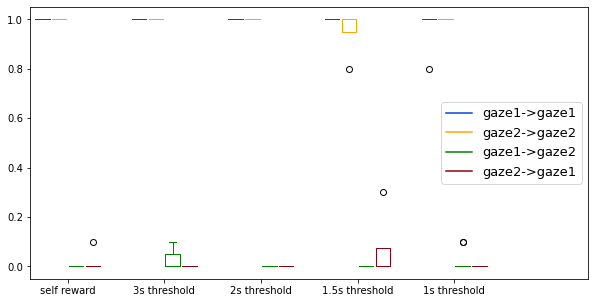

In [48]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze1_gaze1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],2,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],2,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],2,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],2,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],2,2],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],2,2]
              ]
gaze2_gaze2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],3,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],3,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],3,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],3,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],3,3],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],3,3]
              ]
gaze1_gaze2 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],2,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],2,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],2,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],2,3],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],2,3],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],2,3]
              ]
gaze2_gaze1 = [DAGs_all_dates[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0],3,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0],3,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0],3,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0],3,2],
               DAGs_all_dates[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0],3,2],
               DAGs_all_dates[np.transpose((tasktypes_all_dates==5))[0],3,2]
              ]
gaze1_gaze1_plot = plt.boxplot(gaze1_gaze1,positions=np.array(np.arange(len(gaze1_gaze1)))*4.0-1.05,widths=0.6)
gaze2_gaze2_plot = plt.boxplot(gaze2_gaze2,positions=np.array(np.arange(len(gaze2_gaze2)))*4.0-0.35,widths=0.6)
gaze1_gaze2_plot = plt.boxplot(gaze1_gaze2,positions=np.array(np.arange(len(gaze1_gaze2)))*4.0+0.35,widths=0.6)
gaze2_gaze1_plot = plt.boxplot(gaze2_gaze1,positions=np.array(np.arange(len(gaze2_gaze1)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_gaze1_plot, '#0343DF', 'gaze1->gaze1')
define_box_properties(gaze2_gaze2_plot, '#FFA500', 'gaze2->gaze2')
define_box_properties(gaze1_gaze2_plot, '#008000', 'gaze1->gaze2')
define_box_properties(gaze2_gaze1_plot, '#8C000F', 'gaze2->gaze1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot between behavioral measures - successful rate vs interpull interval

Text(2, 1, 'corr r = -0.33; corr p = 0.15')

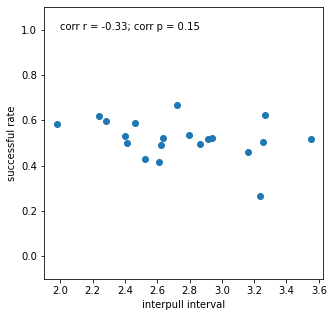

In [49]:
fig, axs = plt.subplots(1,1,figsize=(5, 5))

# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx = interpullintv_all_dates[ind]
yyy = succ_rate_all_dates[ind]
axs.plot(xxx,yyy,'o')
axs.set_xlabel('interpull interval')
axs.set_ylabel('successful rate')
# axs.set_xlim([-0.1,1.1])
axs.set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy)
axs.text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.16; corr p = 0.31')

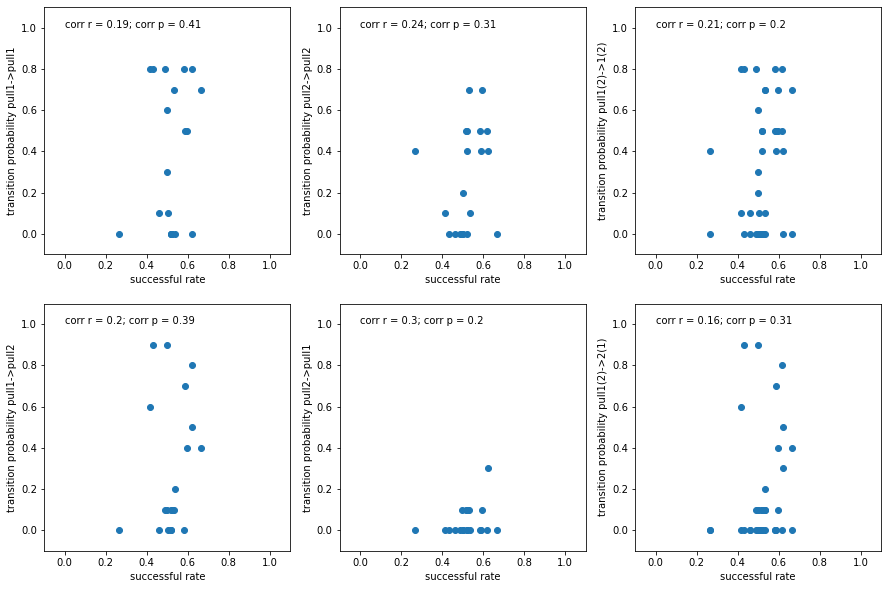

In [50]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)
#
xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull1(2)->2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - interpull interval

Text(2, 1, 'corr r = -0.22; corr p = 0.18')

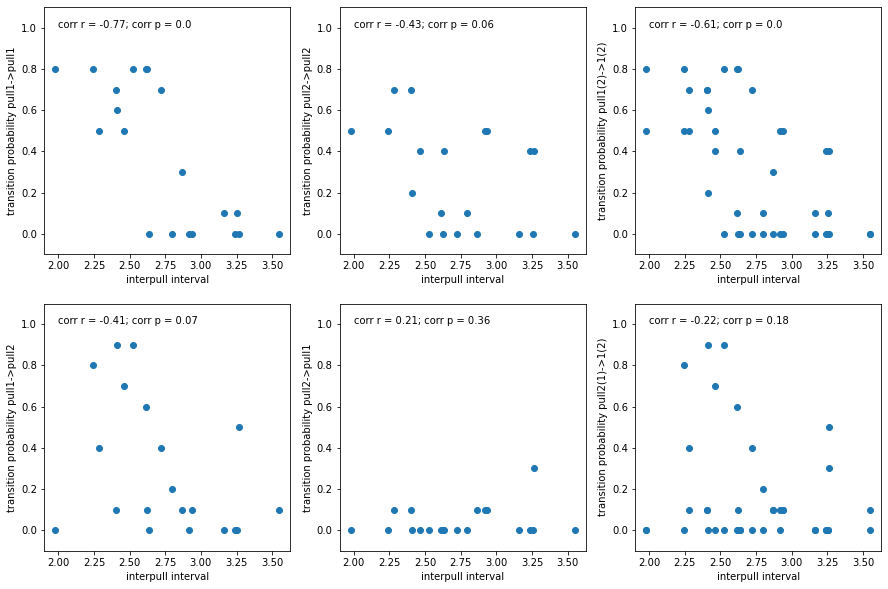

In [51]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx  = interpullintv_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('interpull interval')
axs[0,0].set_ylabel('transition probability '+y1label)
#axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('interpull interval')
axs[0,1].set_ylabel('transition probability '+y2label)
#axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('interpull interval')
axs[1,0].set_ylabel('transition probability '+y3label)
#axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('interpull interval')
axs[1,1].set_ylabel('transition probability '+y4label)
#axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('interpull interval')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
#axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('interpull interval')
axs[1,2].set_ylabel('transition probability pull2(1)->1(2)')
#axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(2, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = -0.11; corr p = 0.5')

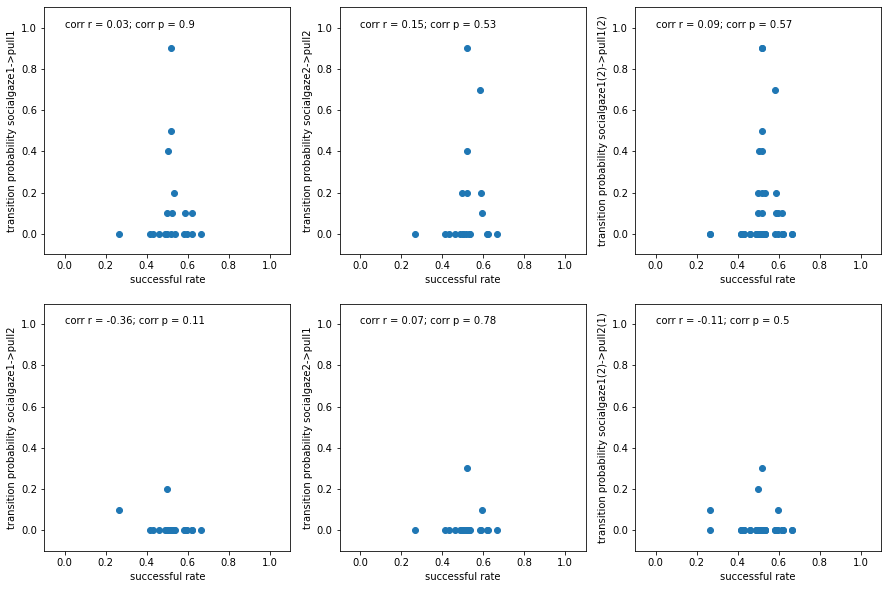

In [52]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the pull -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = -0.14; corr p = 0.38')

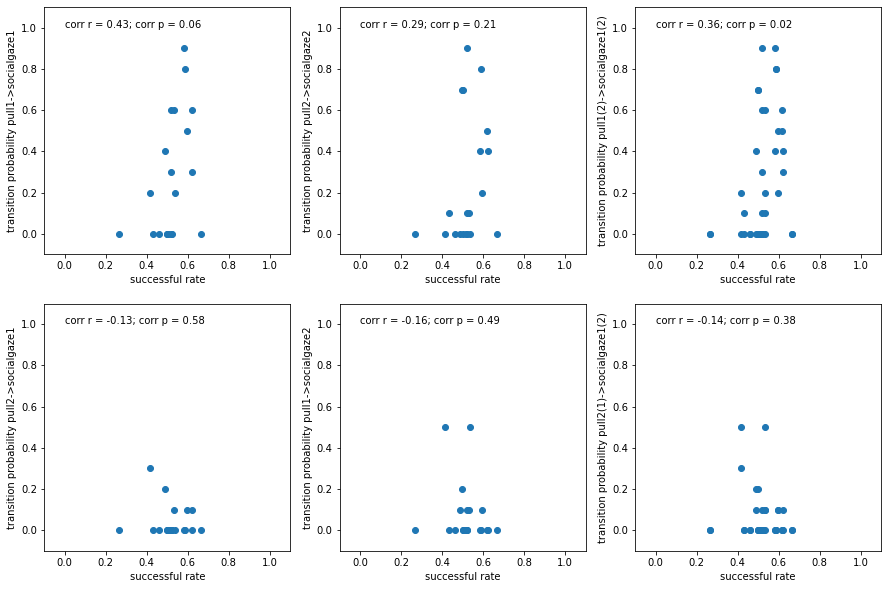

In [53]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,2]
y1label = "pull1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,3]
y2label = "pull2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],1,2]
y3label = "pull2->socialgaze1"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],0,3]
y4label = "pull1->socialgaze2"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = -0.11; corr p = 0.51')

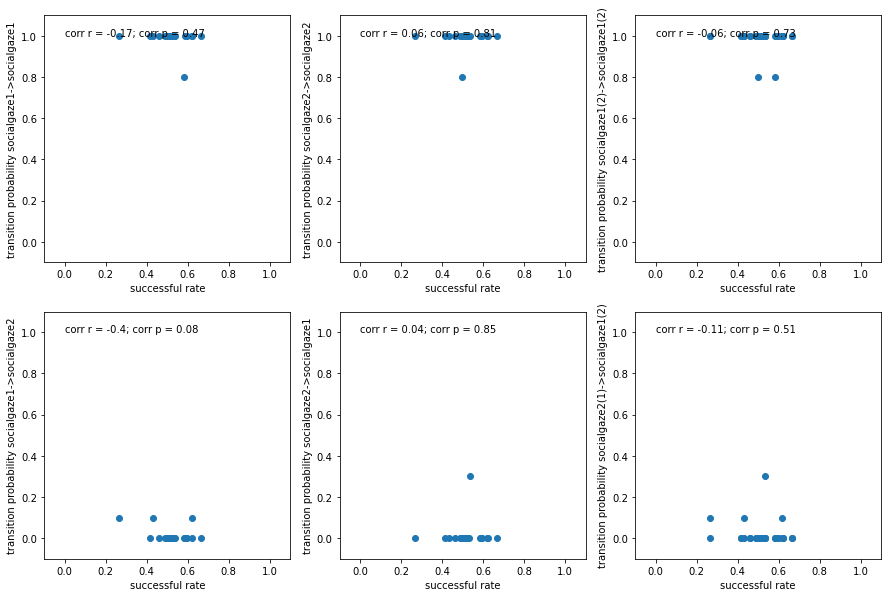

In [54]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,2]
y1label = "socialgaze1->socialgaze1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,3]
y2label = "socialgaze2->socialgaze2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,3]
y3label = "socialgaze1->socialgaze2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,2]
y4label = "socialgaze2->socialgaze1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->socialgaze1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability socialgaze2(1)->socialgaze1(2)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs gaze/pull ratio

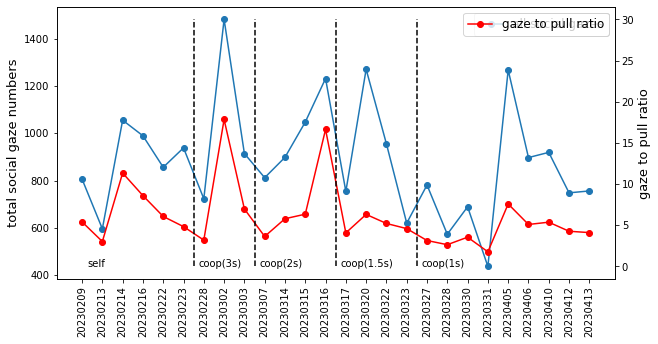

In [55]:
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates':dates_list,'tasktype':tasktypes_all_dates.ravel(),
                           'coopthres':coopthres_all_dates.ravel()}, columns=['dates','tasktype','coopthres'])
sorting_df = sorting_df.sort_values(by=['tasktype','coopthres','dates'], ascending = [True,False,True])

gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(gaze_numbers[sorting_df.index],'o-',label = "all social gazes")

ax1.legend(fontsize=12)
ax1.set_ylabel("total social gaze numbers",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
ax2 = ax1.twinx()
ax2.plot(gaze_pull_ratios[sorting_df.index],'ro-',label = "gaze to pull ratio")
ax2.legend(fontsize=12)
ax2.set_ylabel("gaze to pull ratio",fontsize=13)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','novision']
taskswitches = np.where((np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)|
                        (np.array(sorting_df['tasktype'])[1:]-np.array(sorting_df['tasktype'])[:-1]!=0))[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax2.plot([taskswitch,taskswitch],[0,30],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax2.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

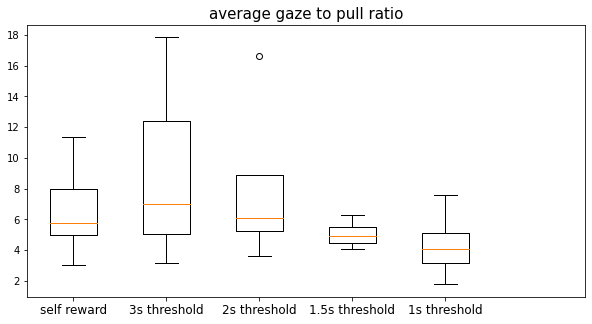

In [56]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze_numbers_groups = [np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==5))[0]])[0]
       
                      ]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average gaze to pull ratio',fontsize = 15);

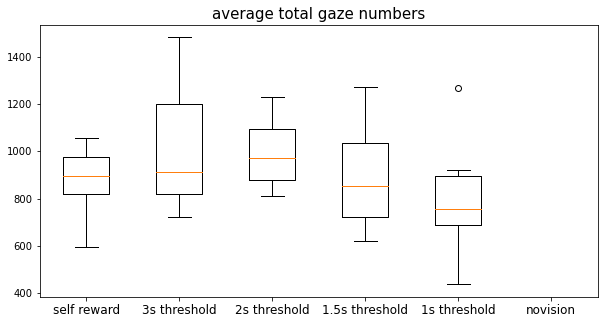

In [57]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose((coopthres_all_dates==0)&(tasktypes_all_dates==1))[0]])[0],
                       np.transpose(gaze_numbers[np.transpose((coopthres_all_dates==3)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_numbers[np.transpose((coopthres_all_dates==2)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_numbers[np.transpose((coopthres_all_dates==1.5)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_numbers[np.transpose((coopthres_all_dates==1)&(tasktypes_all_dates==3))[0]])[0],
                       np.transpose(gaze_numbers[np.transpose((tasktypes_all_dates==5))[0]])[0]
                      ]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average total gaze numbers',fontsize = 15);

Text(0, 1, 'corr r = 0.12; corr p = 0.48')

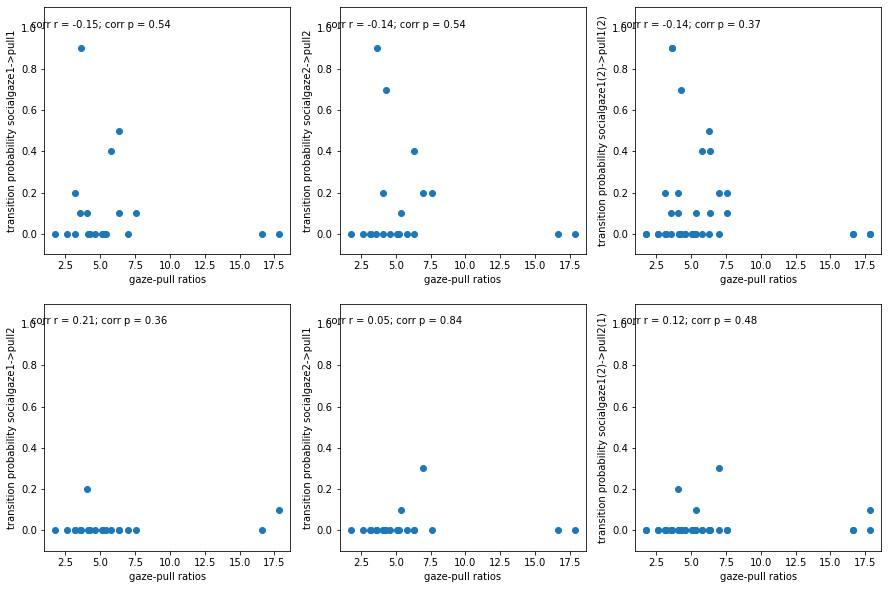

In [58]:
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)
# gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = gaze_pull_ratios[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],2,0]
y1label = "socialgaze1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],3,1]
y2label = "socialgaze2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],2,1]
y3label = "socialgaze1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],3,0]
y4label = "socialgaze2->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('gaze-pull ratios')
axs[0,0].set_ylabel('transition probability '+y1label)
# axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('gaze-pull ratios')
axs[0,1].set_ylabel('transition probability '+y2label)
# axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('gaze-pull ratios')
axs[1,0].set_ylabel('transition probability '+y3label)
# axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('gaze-pull ratios')
axs[1,1].set_ylabel('transition probability '+y4label)
# axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('gaze-pull ratios')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
# axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('gaze-pull ratios')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
# axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))


